## Tomar en cuenta:
- El modelo fue entrenado en Google Colab, a lo cual, los callbacks, import de Glove y datasets estan con rutas de Google Drive.

## Pip install

In [1]:
!pip install bert-for-tf2 #paquete de Bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 388.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30510 sha256=6bc5aea468fbb33e8111702956e9d8c594442e61da545a5ff57fbe3d1d091ce0
  Stored in directory: /root/.cache/pip/wheels/d8/da/50/126d7b8416d9a0e6bf876935c2219a71e72a6529c25e150c56
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19455 sha256=7caadf5e11b226d18b546bf2c4b2aa0e1a8c24b3b779e661fb550d65efd67447
  Stored in directory: /root/.cache/pip/wheels/97/a8/d0/f7419404174976a2686bb98b5c30df01cc71445415f32db9e6
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7891 sha256=8bc7dbd6b8c154dbbacd261d8b910a6e65c249c92e72e54b343a5659da87193c
  Stored in directory: /root/.cache/pip/wheels/69/c8/b3/92666cff9fb312bc3473eaa6b396695b89a7b3e31e9087

In [2]:
!pip install sentencepiece #Para llamar a bert

In [3]:
!pip install transformers #Para realizar la traducción

## Imports

In [4]:
import tensorflow as tf
from google.colab import drive
import numpy as np
import pandas as pd
import keras
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import tensorflow_hub as hub
import matplotlib.pyplot as plt



from sklearn.model_selection import train_test_split
import numpy as np
import math
import re
import pandas as pd #cargar los dataset
from bs4 import BeautifulSoup
import random #mezclar datos
import tensorflow as tf
import tensorflow_hub as hub # para obtener el modelo pre-entrenado de BERT
from tensorflow.keras import layers
import bert
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
import random
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

In [5]:
drive.mount('/content/drive')

dfpathMeld = '/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/meld_train.csv'
dfpathCbet =  '/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/CBET.csv'
dfpathISEAR =  '/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ISEAR.csv'


dfMeld = pd.read_csv(dfpathMeld)
dfCbet = pd.read_csv(dfpathCbet)
dfISEAR= pd.read_csv(dfpathISEAR, header=None)

Mounted at /content/drive


## Análisis y preprocesamiento de datos

#### ISEAR

In [6]:
textoISEAR = dfISEAR[1]
labelISEAR = dfISEAR[0]

data = {
    'texto' : textoISEAR.tolist(),
    'label' : labelISEAR.tolist()
}

dfISEAR = pd.DataFrame(data) #Crear dataframe de isear

In [ ]:
dfISEAR.groupby('label').describe()

texto                                                               
        count unique                                                top freq
label                                                                       
anger    1079   1079  When I had been obviously unjustly treated and...    1
disgust  1066   1065  I saw a program on T.V where they had to saw a...    2
fear     1076   1072                             First time in anatomy.    2
guilt    1049   1048           I felt guilty when I lied to my parents.    2
guit        1      1  At hostel, my roommate was a very selfish pers...    1
joy      1092   1081             When I was admitted to the University.    3
sadness  1082   1054                          When my grandfather died.    8
shame    1071   1061                       Not doing well in the examn.    5

In [ ]:
dfISEAR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7516 entries, 0 to 7515
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   7516 non-null   object
 1   label   7516 non-null   object
dtypes: object(2)
memory usage: 117.6+ KB


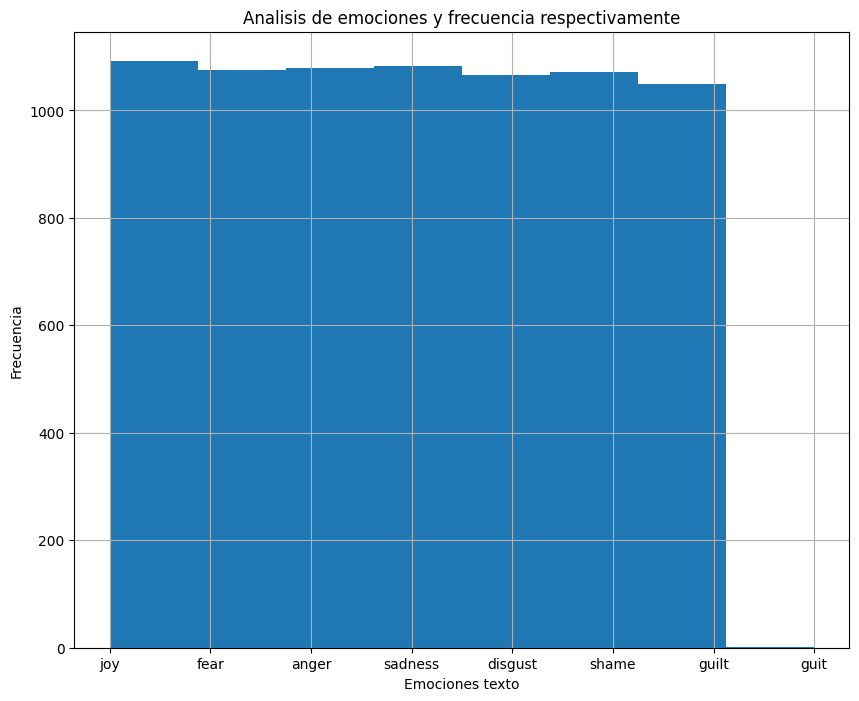

In [ ]:
plt.figure(figsize=(10,8))
dfISEAR['label'].hist(bins=8)
plt.xlabel('Emociones texto')
plt.ylabel('Frecuencia')
plt.title('Analisis de emociones y frecuencia respectivamente')
plt.show()


In [ ]:
dfISEAR['label'].value_counts()

label
joy        1092
sadness    1082
anger      1079
fear       1076
shame      1071
disgust    1066
guilt      1049
guit          1
Name: count, dtype: int64

In [ ]:
print(dfISEAR['label'].unique())

['joy' 'fear' 'anger' 'sadness' 'disgust' 'shame' 'guilt' 'guit']


Se analiza que existen más emociones de las que se van a analizar, por ende, se elimina Shame, Guilt y Guit.
Además es necesario aplicar un balanceo de datos

In [7]:
dfISEAR = dfISEAR.replace(to_replace=['joy', 'anger', 'sadness'], value=['happy', 'angry', 'sad']) #Reemplazar nombres de datos
dfISEAR = dfISEAR.drop(dfISEAR[dfISEAR['label']== 'shame'].index) #Eliminar nombres de datos de emociones que no se ocupan
dfISEAR = dfISEAR.drop(dfISEAR[dfISEAR['label']== 'guilt'].index)
dfISEAR = dfISEAR.drop(dfISEAR[dfISEAR['label']== 'guit'].index)
dfISEAR = dfISEAR.reset_index(drop=True)
dfISEAR

,texto,label
0,On days when I feel close to my partner and ot...,happy
1,Every time I imagine that someone I love or I ...,fear
2,When I had been obviously unjustly treated and...,angry
3,When I think about the short time that we live...,sad
4,At a gathering I found myself involuntarily si...,disgust
...,...,...
5390,My roommate liked to listen to some meaningles...,angry
5391,I received a letter from a distant friend.,happy
5392,My parents were out and I was the eldest at ho...,fear
5393,I was at home and I heard a loud sound of spit...,fear


In [ ]:
print(dfISEAR['label'].unique())

['happy' 'fear' 'angry' 'sad' 'disgust']


#### CBET

In [8]:
labelCBET = dfCbet.iloc[:,2:10]
textoCBET = dfCbet['text']

In [ ]:
labelCBET

,anger,fear,joy,love,sadness,surprise,thankfulness,disgust
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
81158,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
81159,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
81160,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
81161,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Los datos de labels estan actualmente en One-Hot-Encoder a lo cual se realiza la transformación inversa

In [9]:
import pandas as pd

# Obtener el nombre de la columna con el valor máximo en cada fila
labelCBET['emocion'] = labelCBET.idxmax(axis=1)

labelCBET = labelCBET.drop(columns=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise', 'thankfulness', 'disgust'])

In [ ]:
textoCBET.describe()

count                                     81163
unique                                    80926
top       Produce all kinds of Creative Designs
freq                                          3
Name: text, dtype: object

In [ ]:
labelCBET.describe()

,emocion
count,81163
unique,8
top,anger
freq,17613


In [10]:
labelCBET['texto'] = textoCBET

In [11]:
labelCBET = labelCBET.rename(columns={'emocion': 'label'})
dfCBET = labelCBET
dfCBET

,label,texto
0,anger,In hours i have to drive to applegate four hou...
1,anger,When there s no more seats available in a rest...
2,anger,PTGforza when people copy your hard earned wor...
3,anger,I was just researching that online THIS IS WRO...
4,anger,photo Angry #Headmaster milton grimm #MiltonGr...
...,...,...
81158,love,Lol ? #antisocial most men irritate me #mostme...
81159,thankfulness,Be thankful ! god is good #godisgood self ie #...
81160,love,When your dog humps your leg for treats empty ...
81161,sadness,ok i think ill give up this live streaming tv ...


In [ ]:
dfCBET.describe()

,label,texto
count,81163,81163
unique,8,80926
top,anger,Produce all kinds of Creative Designs
freq,17613,3


In [ ]:
dfCBET.groupby('label').describe()

texto                                                            \
              count unique                                                top   
label                                                                           
anger         17613  17563  looking for an i phone repair ! broke my phone...   
disgust        8546   8545  some of you guys out there should never have a...   
fear           9030   9021          How to let go when having a of falling in   
joy           10811  10691  Always wear a beautiful smile #Beautiful #Smil...   
love           9421   9398  Still Im thankful that I had that one great lo...   
sadness        8642   8623  The most unattractive scene is a woman WHO can...   
surprise       8556   8552            Hotel room flower delivery from @user ?   
thankfulness   8544   8544  Thanks for the RT Jon! I appreciate it Have a ...   

                   
             freq  
label              
anger           2  
disgust         2  
fear            2  
joy             2  
love            2  
sadness         2  
surprise        2  
thankfulness    1

In [ ]:
print(dfCBET['label'].unique())

['anger' 'fear' 'joy' 'love' 'sadness' 'surprise' 'thankfulness' 'disgust']


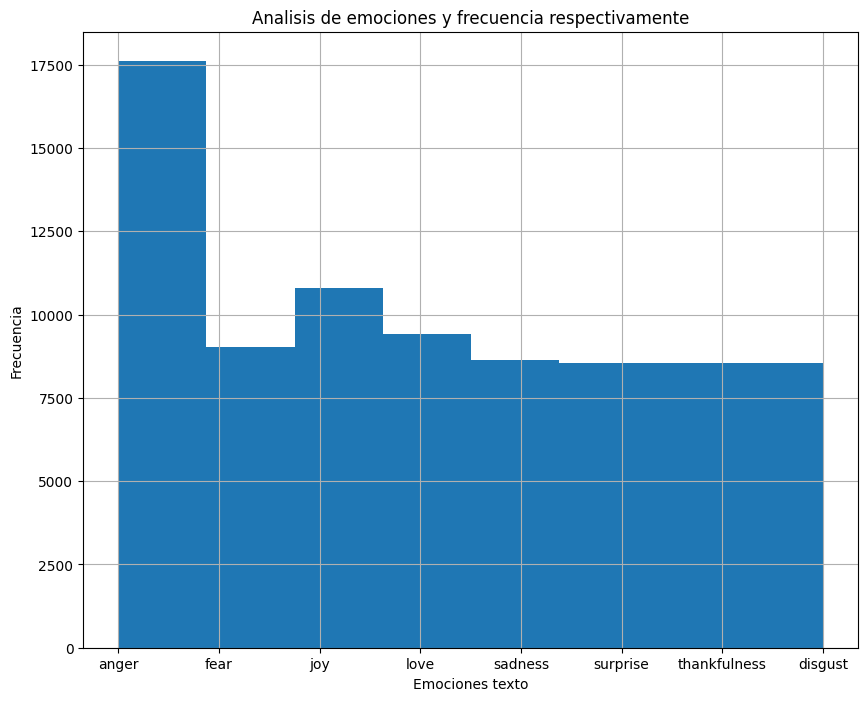

In [ ]:
plt.figure(figsize=(10,8))
dfCBET['label'].hist(bins=8)
plt.xlabel('Emociones texto')
plt.ylabel('Frecuencia')
plt.title('Analisis de emociones y frecuencia respectivamente')
plt.show()


In [ ]:
dfCBET['label'].unique()

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise',
       'thankfulness', 'disgust'], dtype=object)

Se eliminan las emociones que no se van a tener en cuenta en el análisis, como love y thankfulness. Además, se cambia el nombre de joy,anger y sadness por happy, angry y sad, respectivamente, para mantener coherencia con el modelo facial.

In [12]:
dfCBET = dfCBET.replace(to_replace=['joy', 'anger', 'sadness'], value=['happy', 'angry', 'sad'])
dfCBET = dfCBET.drop(dfCBET[dfCBET['label'] == 'love'].index)
dfCBET = dfCBET.drop(dfCBET[dfCBET['label'] == 'thankfulness'].index)

print(dfCBET['label'].unique())

['angry' 'fear' 'happy' 'sad' 'surprise' 'disgust']


In [13]:
dfCBET = dfCBET.reset_index(drop=True)
dfCBET

,label,texto
0,angry,In hours i have to drive to applegate four hou...
1,angry,When there s no more seats available in a rest...
2,angry,PTGforza when people copy your hard earned wor...
3,angry,I was just researching that online THIS IS WRO...
4,angry,photo Angry #Headmaster milton grimm #MiltonGr...
...,...,...
63193,disgust,some of you guys out there should never have a...
63194,disgust,#POS #Bastard #Teen found of #killing #newlywe...
63195,happy,is hard to say but it feels good when its done...
63196,sad,@user #bullied #dislike not friends #notfriend...


In [14]:
datosordenados = {
    'texto' : dfCBET['texto'],
    'label' : dfCBET['label']
}

dfCBET = pd.DataFrame(datosordenados)
dfCBET

,texto,label
0,In hours i have to drive to applegate four hou...,angry
1,When there s no more seats available in a rest...,angry
2,PTGforza when people copy your hard earned wor...,angry
3,I was just researching that online THIS IS WRO...,angry
4,photo Angry #Headmaster milton grimm #MiltonGr...,angry
...,...,...
63193,some of you guys out there should never have a...,disgust
63194,#POS #Bastard #Teen found of #killing #newlywe...,disgust
63195,is hard to say but it feels good when its done...,happy
63196,@user #bullied #dislike not friends #notfriend...,sad


In [ ]:
dfCBET['label'].value_counts() #Datos no balanceados

label
angry       17613
happy       10811
fear         9030
sad          8642
surprise     8556
disgust      8546
Name: count, dtype: int64

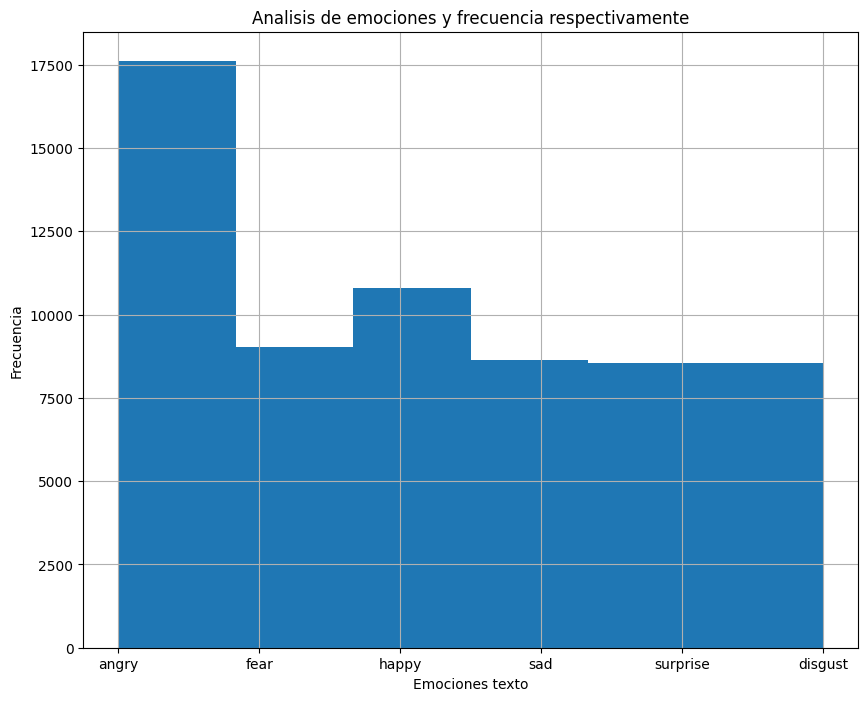

In [ ]:
plt.figure(figsize=(10,8))
dfCBET['label'].hist(bins=6)
plt.xlabel('Emociones texto')
plt.ylabel('Frecuencia')
plt.title('Analisis de emociones y frecuencia respectivamente')
plt.show()

#### MELD

In [15]:
label = dfMeld['Emotion']
text = dfMeld['Utterance']

data = {
    'texto' : text.tolist(),
    'label' : label.tolist()
}

dfMeld= pd.DataFrame(data)

In [ ]:
print(dfMeld['label'].unique())

['neutral' 'surprise' 'fear' 'sadness' 'joy' 'disgust' 'anger']


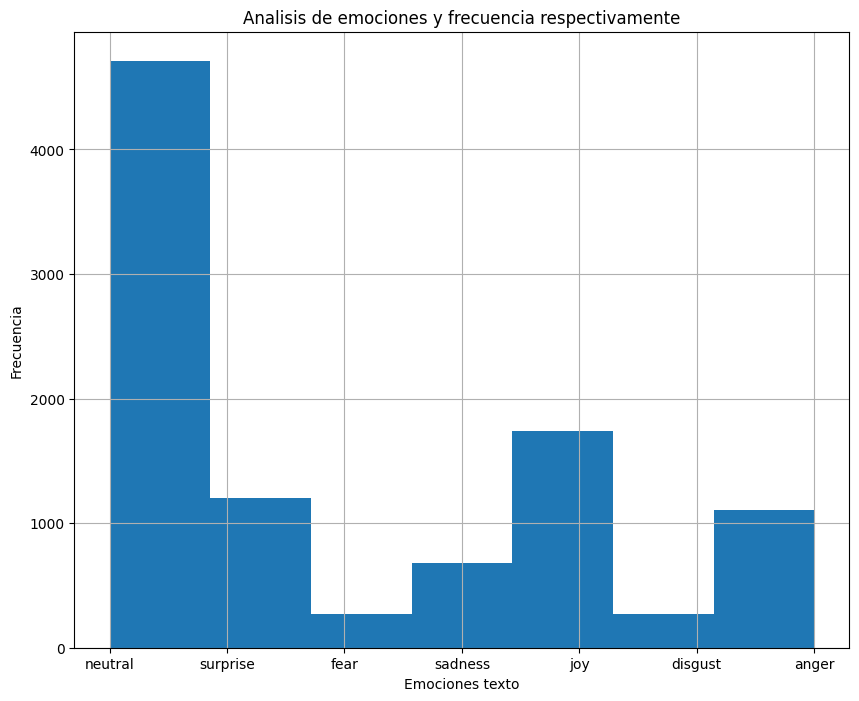

In [ ]:
plt.figure(figsize=(10,8))
dfMeld['label'].hist(bins=7)
plt.xlabel('Emociones texto')
plt.ylabel('Frecuencia')
plt.title('Analisis de emociones y frecuencia respectivamente')
plt.show()

Se cambia el nombre de joy, sadness y anger por happy, sad y angry, respectivamente, para mantener coherencia con el modelo facial

In [16]:
dfMeld = dfMeld.replace(to_replace=['joy', 'sadness', 'anger'], value=['happy', 'sad', 'angry'])
dfMeld

,texto,label
0,also I was the point person on my companys tr...,neutral
1,You mustve had your hands full.,neutral
2,That I did. That I did.,neutral
3,So lets talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
9984,You or me?,neutral
9985,"I got it. Uh, Joey, women don't have Adam's ap...",neutral
9986,"You guys are messing with me, right?",surprise
9987,Yeah.,neutral


In [ ]:
dfMeld['label'].value_counts()

label
neutral     4710
happy       1743
surprise    1205
angry       1109
sad          683
disgust      271
fear         268
Name: count, dtype: int64

Existen desbalanceo en los 3 datasets

#### Concadenación de los 3 datasets

In [17]:
dftodo = pd.concat([dfMeld, dfCBET, dfISEAR])
dftodo

,texto,label
0,also I was the point person on my companys tr...,neutral
1,You mustve had your hands full.,neutral
2,That I did. That I did.,neutral
3,So lets talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
5390,My roommate liked to listen to some meaningles...,angry
5391,I received a letter from a distant friend.,happy
5392,My parents were out and I was the eldest at ho...,fear
5393,I was at home and I heard a loud sound of spit...,fear


In [ ]:
dftodo.describe()

,texto,label
count,78582,78582
unique,77269,7
top,Hey!,angry
freq,79,19801


In [ ]:
dftodo.groupby('label').describe()

texto                                                               
          count unique                                                top freq
label                                                                         
angry     19801  19707                                                No!   13
disgust    9883   9880  some of you guys out there should never have a...    2
fear      10374  10357                                             Uh-oh.    4
happy     13646  13361                                               Hey!   45
neutral    4710   4211                                              Okay.   63
sad       10407  10345                          When my grandfather died.    8
surprise   9761   9558                                              What?   39

In [ ]:
print(dftodo['label'].unique())

['neutral' 'surprise' 'fear' 'sad' 'happy' 'disgust' 'angry']


In [ ]:
dftodo['label'].value_counts()

label
angry       19801
happy       13646
sad         10407
fear        10374
disgust      9883
surprise     9761
neutral      4710
Name: count, dtype: int64

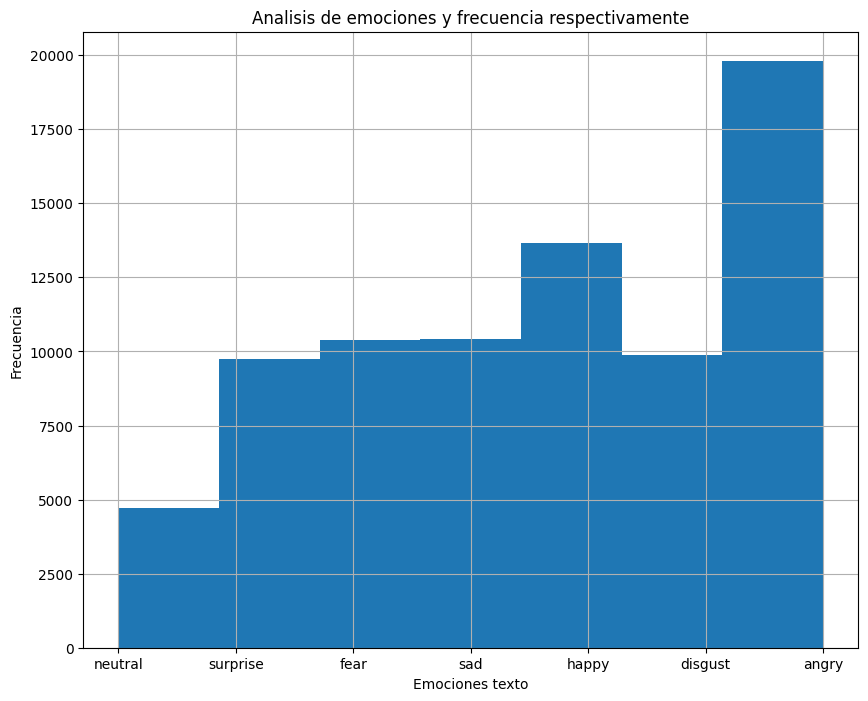

In [ ]:
plt.figure(figsize=(10,8))
dftodo['label'].hist(bins=7)
plt.xlabel('Emociones texto')
plt.ylabel('Frecuencia')
plt.title('Analisis de emociones y frecuencia respectivamente')
plt.show()

In [ ]:
nullvalues = dftodo.isnull().sum()
print('Valores nulos:', nullvalues)

Valores nulos: texto    0
label    0
dtype: int64


Con la concatenación de los 3 conjuntos de datos quedaron 78.582 datos. Estos datos poseen 7 etiquetas y están desbalanceados. Por ende, el siguiente paso es el balanceo de datos. Además, los datos no poseen datos nulos.

### Balanceo de datos

In [18]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd


over_sampler = RandomOverSampler(random_state=42) #Se aplica Oversampling

# Sobremuestrear el dataframe
X_resampled, y_resampled = over_sampler.fit_resample(dftodo[['texto']], dftodo['label'])

# Crear un nuevo dataframe con los datos sobremuestreados
df_resampled = pd.DataFrame(X_resampled, columns=['texto'])
df_resampled['label'] = y_resampled

In [ ]:
df_resampled['label'].value_counts()

neutral     19801
surprise    19801
fear        19801
sad         19801
happy       19801
disgust     19801
angry       19801
Name: label, dtype: int64

In [ ]:
df_resampled

,texto,label
0,also I was the point person on my companys tr...,neutral
1,You mustve had your hands full.,neutral
2,That I did. That I did.,neutral
3,So lets talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
138602,Aerotek #Manufacturing #Job Maintenance Techni...,surprise
138603,Breaking news Loop reopens hours after fatal c...,surprise
138604,Starving hungry and just found some dark choco...,surprise
138605,Are you jealous?,surprise


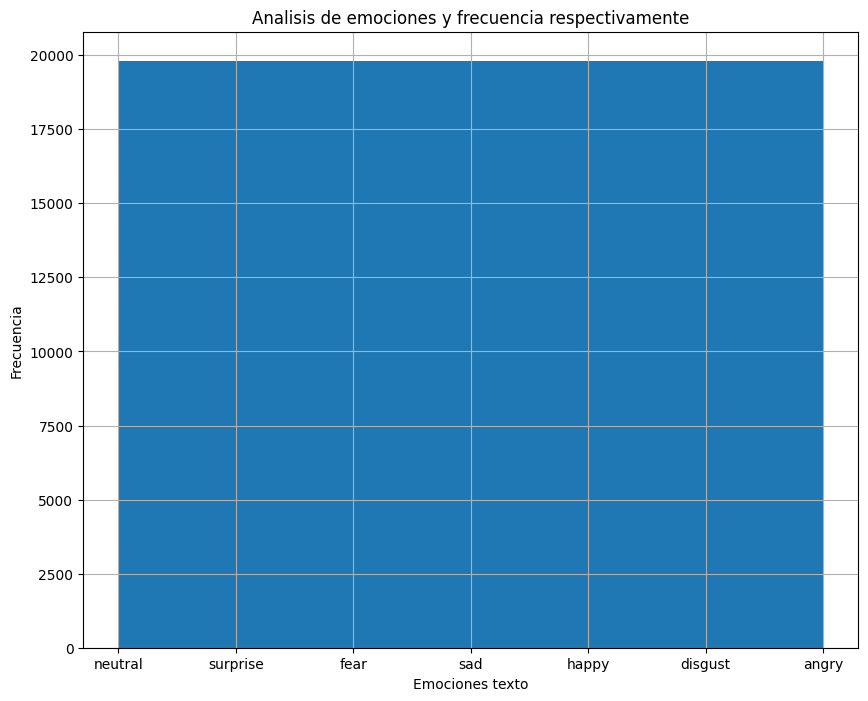

In [ ]:
plt.figure(figsize=(10,8))
df_resampled['label'].hist(bins=7)
plt.xlabel('Emociones texto')
plt.ylabel('Frecuencia')
plt.title('Analisis de emociones y frecuencia respectivamente')
plt.show()

Al aplicar OverSampling, se logra un equilibrio en los datos al igualar la cantidad de muestras al valor de la clase mayoritaria, lo que resulta en 19.801 datos para cada clase. Esto aumenta el tamaño del conjunto de datos a 138.607.

### Limpieza de datos

In [19]:
import re

#Función para limpiar el texto
def clean_emotion_text(texto): #recibe un texto como entrada

  #eliminar los @ seguido con el nombre para eliminar correos, nombres de usuario, etc..
  texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
  #todo lo que encuentra es reemplazado por un espacio en blanco ' '

  #eliminar los links de la url
  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
  #todo lo que encuentra es reemplazado por un espacio en blanco ' '


  #Conversar solo las letras, caracteres como ! y ? que pueden ser importantes para las emociones y eliminar lo demas
  texto = re.sub(r"[^a-zA-Z.!?]", ' ', texto)
  #todo lo que encuentra es reemplazado por un espacio en blanco ' '

  #Eliminar espacios en blanco adicionales
  texto = re.sub(r" +", ' ', texto)


  return texto #retorna la data limpiada

# LLamado a la función de limpieza
texto_clean = [clean_emotion_text(texto) for texto in df_resampled['texto']]

In [20]:
texto_clean

['also I was the point person on my company s transition from the KL to GR system.',
 'You must ve had your hands full.',
 'That I did. That I did.',
 'So let s talk a little bit about your duties.',
 'My duties? All right.',
 'Now you ll be heading a whole division so you ll have a lot of duties.',
 'I see.',
 'But there ll be perhaps people under you so you can dump a certain amount on them.',
 'Good to know.',
 'We can go into detail',
 'No don t I beg of you!',
 'All right then we ll have a definite answer for you on Monday but I think I can say with some confidence you ll fit in well here.',
 'Really?!',
 'Absolutely. You can relax',
 'But then who? The waitress I went out with last month?',
 'You know? Forget it!',
 'No no no no no! Who who were you talking about?',
 'No I I I I don t I actually don t know',
 'Ok!',
 'All right well...',
 'Yeah sure!',
 'Hey Mon.',
 'Hey hey hey. You wanna hear something that sucks.',
 'Do I ever.',
 'Chris says they re closing down the bar.',
 '

### LabelEncoder

Se transforman las etiquetas a valores numéricos

In [21]:
labels = df_resampled['label']

le = LabelEncoder()

labelEncoder = le.fit_transform(labels)

data_labels = labelEncoder

In [ ]:
le.classes_

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

In [ ]:
# Obtener los nombres de las clases
class_names = le.classes_

# Obtener los valores numéricos asignados a cada clase
class_values = le.transform(class_names)

# Imprimir los nombres de las clases y sus valores numéricos
for name, value in zip(class_names, class_values):
    print(f'Clase: {name}, Valor: {value}')

Clase: angry, Valor: 0
Clase: disgust, Valor: 1
Clase: fear, Valor: 2
Clase: happy, Valor: 3
Clase: neutral, Valor: 4
Clase: sad, Valor: 5
Clase: surprise, Valor: 6


# Tokenización y creación de dataset

In [ ]:
data_labels

array([4, 4, 4, ..., 6, 6, 6])

In [ ]:
texto_clean

['also I was the point person on my company s transition from the KL to GR system.',
 'You must ve had your hands full.',
 'That I did. That I did.',
 'So let s talk a little bit about your duties.',
 'My duties? All right.',
 'Now you ll be heading a whole division so you ll have a lot of duties.',
 'I see.',
 'But there ll be perhaps people under you so you can dump a certain amount on them.',
 'Good to know.',
 'We can go into detail',
 'No don t I beg of you!',
 'All right then we ll have a definite answer for you on Monday but I think I can say with some confidence you ll fit in well here.',
 'Really?!',
 'Absolutely. You can relax',
 'But then who? The waitress I went out with last month?',
 'You know? Forget it!',
 'No no no no no! Who who were you talking about?',
 'No I I I I don t I actually don t know',
 'Ok!',
 'All right well...',
 'Yeah sure!',
 'Hey Mon.',
 'Hey hey hey. You wanna hear something that sucks.',
 'Do I ever.',
 'Chris says they re closing down the bar.',
 '

In [ ]:
textLower = [texts.lower() for texts in texto_clean]
textLower

['also i was the point person on my company s transition from the kl to gr system.',
 'you must ve had your hands full.',
 'that i did. that i did.',
 'so let s talk a little bit about your duties.',
 'my duties? all right.',
 'now you ll be heading a whole division so you ll have a lot of duties.',
 'i see.',
 'but there ll be perhaps people under you so you can dump a certain amount on them.',
 'good to know.',
 'we can go into detail',
 'no don t i beg of you!',
 'all right then we ll have a definite answer for you on monday but i think i can say with some confidence you ll fit in well here.',
 'really?!',
 'absolutely. you can relax',
 'but then who? the waitress i went out with last month?',
 'you know? forget it!',
 'no no no no no! who who were you talking about?',
 'no i i i i don t i actually don t know',
 'ok!',
 'all right well...',
 'yeah sure!',
 'hey mon.',
 'hey hey hey. you wanna hear something that sucks.',
 'do i ever.',
 'chris says they re closing down the bar.',
 '

## Tokenización

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(textLower)
sequences = tokenizer.texts_to_sequences(textLower)
sequences

[[334, 2, 19, 1, 692, 216, 15, 9, 1135, 17, 7530, 39, 1, 6666, 3, 2833, 1077],
 [5, 376, 251, 50, 27, 723, 482],
 [13, 2, 110, 13, 2, 110],
 [22, 139, 17, 267, 4, 159, 657, 45, 27, 7207],
 [9, 7207, 34, 86],
 [62, 5, 218, 23, 3030, 4, 458, 4206, 22, 5, 218, 26, 4, 345, 7, 7207],
 [2, 80],
 [35, 66, 218, 23, 3465, 49, 604, 5, 22, 5, 32, 3709, 4, 923, 1652, 15, 140],
 [60, 3, 44],
 [30, 32, 65, 188, 4115],
 [29, 154, 33, 2, 5825, 7, 5],
 [34,
  86,
  145,
  30,
  218,
  26,
  4,
  9207,
  942,
  12,
  5,
  15,
  685,
  35,
  2,
  89,
  2,
  32,
  158,
  18,
  85,
  588,
  5,
  218,
  810,
  8,
  83,
  92],
 [79],
 [603, 5, 32, 1170],
 [35, 145, 64, 1, 13170, 2, 284, 38, 18, 149, 693],
 [5, 44, 632, 11],
 [29, 29, 29, 29, 29, 64, 64, 111, 5, 452, 45],
 [29, 2, 2, 2, 2, 154, 33, 2, 275, 154, 33, 44],
 [352],
 [34, 86, 83],
 [94, 323],
 [131, 1763],
 [131, 131, 131, 5, 322, 448, 155, 13, 881],
 [36, 2, 156],
 [1920, 488, 54, 74, 3780, 169, 1, 894],
 [29, 127],
 [94, 913, 54, 74, 1963, 11, 1

## Creación de entrada con dataset por batches

In [ ]:
import tensorflow as tf
import random
from sklearn.preprocessing import StandardScaler



# Combinar texto, etiquetas y largo en data_with_len
data_with_len = [(sent, label, len(sent)) for label, sent in zip(data_labels, sequences)]
random.shuffle(data_with_len) #Se desordena los datos

# Ordenar por longitud de sentencia
data_with_len.sort(key=lambda x: x[2])


# Función generadora para el dataset
def generator():
    for sent, label, _ in data_with_len:
        yield tf.constant(sent, dtype=tf.int32), tf.constant(label, dtype=tf.int32)

# Crear el dataset a partir del generador
all_dataset = tf.data.Dataset.from_generator(generator,
                                             output_types=(tf.int32, tf.int32))

# Batch y padding del dataset
batch_size = 128
all_batched = all_dataset.padded_batch(batch_size,
                                       padded_shapes=([300], []),
                                       padding_values=(0, 0))


Instructions for updating:
Use output_signature instead


In [ ]:
len(data_with_len)

138607

In [ ]:
# Mostrar:
next(iter(all_batched))

(<tf.Tensor: shape=(128, 300), dtype=int32, numpy=
 array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [ 29,   0,   0, ...,   0,   0,   0],
        [259,   0,   0, ...,   0,   0,   0],
        [131,   0,   0, ...,   0,   0,   0]], dtype=int32)>,
 <tf.Tensor: shape=(128,), dtype=int32, numpy=
 array([4, 5, 2, 0, 0, 5, 4, 4, 0, 2, 4, 5, 0, 0, 4, 5, 4, 3, 0, 4, 2, 4,
        0, 0, 4, 0, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4,
        3, 6, 6, 4, 4, 4, 6, 6, 4, 6, 4, 4, 4, 4, 5, 5, 4, 4, 5, 6, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 3, 1, 4, 3, 4, 4, 4, 4,
        4, 4, 4, 4, 3, 4, 4, 0, 4, 0, 3, 4, 4, 4, 6, 4, 4, 4, 4, 1, 6, 3,
        4, 4, 6, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4], dtype=int32)>)

In [ ]:

import math

BATCH_SIZE=128

# Calcular el número total de lotes
NB_BATCHES = math.ceil(len(data_with_len) / BATCH_SIZE)
print("NB_BATCHES totales: ",NB_BATCHES)

# Calcular el número de lotes para validación y prueba
NB_BATCHES_VAL = (NB_BATCHES * 20) // 100
NB_BATCHES_TEST = (NB_BATCHES * 10) // 100
print("NB_BATCHES validacion: ",NB_BATCHES_VAL)
print("NB_BATCHES testeo: ",NB_BATCHES_TEST)
print("NB_BATCHES entrenamiento", NB_BATCHES - (NB_BATCHES_TEST + NB_BATCHES_VAL))


# Mezclar el conjunto de datos
all_batched = all_batched.shuffle(NB_BATCHES)

# Crear conjuntos de datos para entrenamiento, validación y prueba
val_dataset = all_batched.take(NB_BATCHES_VAL)
train_dataset = all_batched.skip(NB_BATCHES_VAL).skip(NB_BATCHES_TEST).take(NB_BATCHES - (NB_BATCHES_TEST + NB_BATCHES_VAL))
test_dataset = all_batched.skip(NB_BATCHES_VAL).take(NB_BATCHES_TEST)

NB_BATCHES totales:  1083
NB_BATCHES validacion:  216
NB_BATCHES testeo:  108
NB_BATCHES entrenamiento 759


In [ ]:
print("Número de textos para validación: ", NB_BATCHES_VAL*128)
print("Número de textos para testeo: ", NB_BATCHES_TEST*128)
print("Número de textos para entrenamiento: ", (NB_BATCHES - (NB_BATCHES_TEST + NB_BATCHES_VAL))*128)

Número de textos para validación:  27648
Número de textos para testeo:  13824
Número de textos para entrenamiento:  97152


In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

75255

# LSTM

In [ ]:
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, Input, LeakyReLU, Dropout
from keras.models import Sequential, Model


maximo_largo_secuencias=300

input_seq  = Input(shape=(maximo_largo_secuencias,), dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=maximo_largo_secuencias, input_length=maximo_largo_secuencias)(input_seq)
lstm1 = LSTM(32, return_sequences=True)(embedding_layer)
dropout = Dropout(0.5)(lstm1)
lstm2 = LSTM(32)(dropout)
dense = Dense(32)(lstm2)
dense = LeakyReLU(alpha=0.2)(dense)
output = Dense(7, activation="softmax")(dense)

modelLstm = Model(inputs=input_seq, outputs=output)

modelLstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

modelLstm.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 300)          22576500  
                                                                 
 lstm (LSTM)                 (None, 300, 32)           42624     
                                                                 
 dropout (Dropout)           (None, 300, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32)                0     

In [ ]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/LSTM/64batch', exist_ok=True)

checkpoint_path = '/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/LSTM/64batch/best_model_modelLSTM_{epoch}_{val_sparse_categorical_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/LSTM/64batch', exist_ok=True)


log_dir = "/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/LSTM/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
historyLstm = modelLstm.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint, tensorboard_callback]
)

Epoch 1/10
    759/Unknown - 196s 177ms/step - loss: 1.9471 - sparse_categorical_accuracy: 0.1434
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.14381, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/LSTM/64batch/best_model_modelLSTM_1_0.1438.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


759/759 [==============================] - 253s 252ms/step - loss: 1.9471 - sparse_categorical_accuracy: 0.1434 - val_loss: 1.9461 - val_sparse_categorical_accuracy: 0.1438
Epoch 2/10
759/759 [==============================] - ETA: 0s - loss: 1.9461 - sparse_categorical_accuracy: 0.1398
Epoch 2: val_sparse_categorical_accuracy improved from 0.14381 to 0.14614, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/LSTM/64batch/best_model_modelLSTM_2_0.1461.h5
759/759 [==============================] - 138s 121ms/step - loss: 1.9461 - sparse_categorical_accuracy: 0.1398 - val_loss: 1.9455 - val_sparse_categorical_accuracy: 0.1461
Epoch 3/10
759/759 [==============================] - ETA: 0s - loss: 1.9463 - sparse_categorical_accuracy: 0.1425
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.14614
759/759 [==============================] - 124s 102ms/step - loss: 1.9463 - sparse_categorical_accuracy: 0.1425 - val_loss: 1.9460 - v

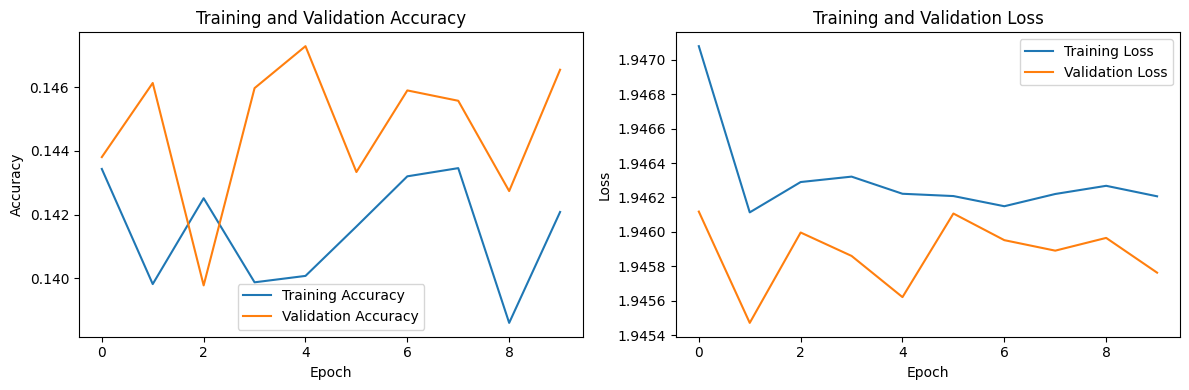

In [ ]:
import matplotlib.pyplot as plt


accuracy = historyLstm.history['sparse_categorical_accuracy']
loss = historyLstm.history['loss']
val_accuracy = historyLstm.history['val_sparse_categorical_accuracy']
val_loss = historyLstm.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# BiLSTM

In [ ]:
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, Input, LeakyReLU
from keras.models import Sequential, Model


maximo_largo_secuencias=300

input_seq  = Input(shape=(maximo_largo_secuencias,), dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=maximo_largo_secuencias, input_length=maximo_largo_secuencias)(input_seq)
lstm1 = Bidirectional(LSTM(32, return_sequences=True))(embedding_layer)
dropout = Dropout(0.5)(lstm1)
lstm2 = Bidirectional(LSTM(32))(dropout)
dense = Dense(32)(lstm2)
dense = LeakyReLU(alpha=0.2)(dense)
output = Dense(7, activation="softmax")(dense)

modelBiLstm = Model(inputs=input_seq, outputs=output)

modelBiLstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

modelBiLstm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 300, 300)          22576500  
                                                                 
 bidirectional (Bidirection  (None, 300, 64)           85248     
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 300, 64)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 32)                2080

In [ ]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BiLSTM/64batch', exist_ok=True)

checkpoint_path = '/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BiLSTM/64batch/best_model_modelLSTM_{epoch}_{val_sparse_categorical_accuracy:.4f}.h5'

#Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/BiLSTM/64batch', exist_ok=True)



log_dir = "/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/BiLSTM/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historyBiLstm = modelBiLstm.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint, tensorboard_callback]
)

Epoch 1/10
    758/Unknown - 141s 115ms/step - loss: 1.2263 - sparse_categorical_accuracy: 0.5502
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.74356, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BiLSTM/64batch/best_model_modelLSTM_1_0.7436.h5
759/759 [==============================] - 233s 235ms/step - loss: 1.2261 - sparse_categorical_accuracy: 0.5503 - val_loss: 0.7923 - val_sparse_categorical_accuracy: 0.7436
Epoch 2/10
758/759 [============================>.] - ETA: 0s - loss: 0.7231 - sparse_categorical_accuracy: 0.7628
Epoch 2: val_sparse_categorical_accuracy improved from 0.74356 to 0.84440, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BiLSTM/64batch/best_model_modelLSTM_2_0.8444.h5
759/759 [==============================] - 190s 189ms/step - loss: 0.7226 - sparse_categorical_accuracy: 0.7630 - val_loss: 0.5003 - val_sparse_categorical_accuracy: 0.8444


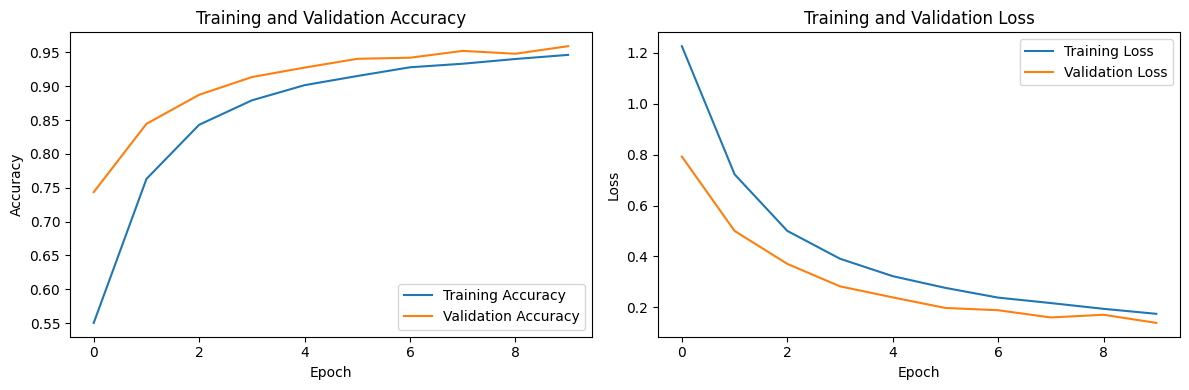

In [ ]:
import matplotlib.pyplot as plt


accuracy = historyBiLstm.history['sparse_categorical_accuracy']
loss = historyBiLstm.history['loss']
val_accuracy = historyBiLstm.history['val_sparse_categorical_accuracy']
val_loss = historyBiLstm.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# BiLSTM + CNN

### n-grams

In [ ]:
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, Input, LeakyReLU, Flatten, Dropout,GlobalMaxPool1D, Concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.regularizers import L2

vocab_size = len(tokenizer.word_index) + 1

maximo_largo_secuencias=300

input_seq  = Input(shape=(maximo_largo_secuencias,), dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=maximo_largo_secuencias, input_length=maximo_largo_secuencias)(input_seq)
lstm1 = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
Conv1Bigram = Conv1D(100, kernel_size=2, padding='same', kernel_initializer='he_uniform')(lstm1)
Pool1 = GlobalMaxPool1D()(Conv1Bigram)
Conv2Trigram = Conv1D(100, kernel_size=3, padding='same', kernel_initializer='he_uniform')(lstm1)
Pool2 = GlobalMaxPool1D()(Conv2Trigram)
Conv3Fourgram = Conv1D(100, kernel_size=4, padding='same', kernel_initializer='he_uniform')(lstm1)
Pool3 = GlobalMaxPool1D()(Conv3Fourgram)

merged = tf.concat([Pool1,Pool2,Pool3], axis=-1)
dense = Dense(256, kernel_regularizer=L2(0.01), bias_regularizer=L2(0.01))(merged)
dropout2 = Dropout(0.2)(dense)
output = Dense(7, activation="softmax")(dropout2)

modelBiLstmCNN_Gram = Model(inputs=input_seq, outputs=output)

modelBiLstmCNN_Gram.compile(optimizer=Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

modelBiLstmCNN_Gram.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 300, 300)             2257650   ['input_3[0][0]']             
                                                          0                                       
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 300, 128)             186880    ['embedding_2[0][0]']         
 onal)                                                                                            
                                                                                            

In [ ]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BiLSTMWithCNNNGram/128batch', exist_ok=True)

checkpoint_path = '/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BiLSTMWithCNNNGram/128batch/best_model_modelBiLstmNgram_{epoch}_{val_sparse_categorical_accuracy:.4f}.h5'

#Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/BiLSTMWithCNNNGram/128batch', exist_ok=True)



log_dir = "/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/BiLSTMWithCNNNGram/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
HistorymodelBiLstmCNN_Gram = modelBiLstmCNN_Gram.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    callbacks=[model_checkpoint, tensorboard_callback]
)

Epoch 1/25
    759/Unknown - 144s 118ms/step - loss: 2.8213 - sparse_categorical_accuracy: 0.3672
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.57397, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BiLSTMWithCNNNGram/128batch/best_model_modelBiLstmNgram_1_0.5740.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


759/759 [==============================] - 204s 198ms/step - loss: 2.8213 - sparse_categorical_accuracy: 0.3672 - val_loss: 1.5972 - val_sparse_categorical_accuracy: 0.5740
Epoch 2/25
759/759 [==============================] - ETA: 0s - loss: 1.2652 - sparse_categorical_accuracy: 0.6233
Epoch 2: val_sparse_categorical_accuracy improved from 0.57397 to 0.71264, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BiLSTMWithCNNNGram/128batch/best_model_modelBiLstmNgram_2_0.7126.h5
759/759 [==============================] - 189s 187ms/step - loss: 1.2652 - sparse_categorical_accuracy: 0.6233 - val_loss: 0.9504 - val_sparse_categorical_accuracy: 0.7126
Epoch 3/25
759/759 [==============================] - ETA: 0s - loss: 0.8695 - sparse_categorical_accuracy: 0.7289
Epoch 3: val_sparse_categorical_accuracy improved from 0.71264 to 0.79170, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BiLSTMWi

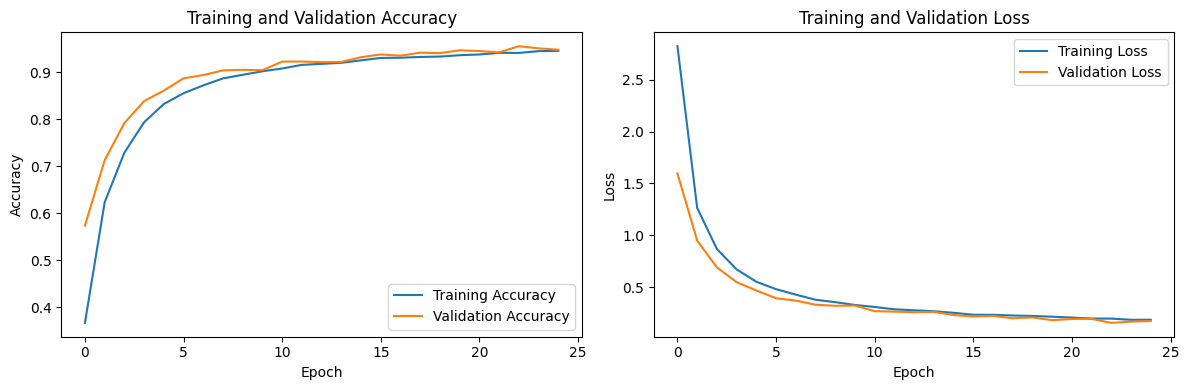

In [ ]:
import matplotlib.pyplot as plt


accuracy = HistorymodelBiLstmCNN_Gram.history['sparse_categorical_accuracy']
loss = HistorymodelBiLstmCNN_Gram.history['loss']
val_accuracy = HistorymodelBiLstmCNN_Gram.history['val_sparse_categorical_accuracy']
val_loss = HistorymodelBiLstmCNN_Gram.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Arquitectura CNN en medio de capas LSTM

In [ ]:
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, Input, LeakyReLU, Flatten, Dropout
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.regularizers import L2

vocab_size = len(tokenizer.word_index) + 1

maximo_largo_secuencias=300

input_seq  = Input(shape=(maximo_largo_secuencias,), dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=maximo_largo_secuencias, input_length=maximo_largo_secuencias)(input_seq)
Conv1 = Conv1D(200, kernel_size=3, padding='same', kernel_initializer='he_uniform')(embedding_layer)
lstm1 = Bidirectional(LSTM(128, return_sequences=True))(Conv1)
dropout = Dropout(0.5)(lstm1)
Conv2 = Conv1D(128, kernel_size=3, padding='same', kernel_initializer='he_uniform')(dropout)
lstm2 = Bidirectional(LSTM(32))(Conv2)
dropout2 = Dropout(0.3)(lstm2)
dense = Dense(50, kernel_regularizer=L2(0.01), bias_regularizer=L2(0.01))(dropout2)
dense = Dense(50, kernel_regularizer=L2(0.01), bias_regularizer=L2(0.01))(dense)
flatten = Flatten()(dense)
dense = Dense(100, kernel_regularizer=L2(0.01), bias_regularizer=L2(0.01))(dense)
output = Dense(7, activation="softmax")(dense)

modelBiLstmCNN = Model(inputs=input_seq, outputs=output)

modelBiLstmCNN.compile(optimizer=Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

modelBiLstmCNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 300)          22576500  
                                                                 
 conv1d (Conv1D)             (None, 300, 200)          180200    
                                                                 
 bidirectional (Bidirection  (None, 300, 256)          336896    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 300, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 300, 128)          98432     
                                                             

In [ ]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BiLSTMWithCNN25MasCapas2/128batch', exist_ok=True)

checkpoint_path = '/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BiLSTMWithCNN25MasCapas2/128batch/best_model_modelLSTM_{epoch}_{val_sparse_categorical_accuracy:.4f}.h5'

#Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/BiLSTMWithCNN25MasCapas2/128batch', exist_ok=True)



log_dir = "/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/BiLSTMWithCNN25MasCapas2/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
HistorymodelBiLstmCNN2 = modelBiLstmCNN.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    callbacks=[model_checkpoint, tensorboard_callback]
)

Epoch 1/25
    759/Unknown - 219s 204ms/step - loss: 2.8545 - sparse_categorical_accuracy: 0.3451
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.50094, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BiLSTMWithCNN25MasCapas2/128batch/best_model_modelLSTM_1_0.5009.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


759/759 [==============================] - 282s 287ms/step - loss: 2.8545 - sparse_categorical_accuracy: 0.3451 - val_loss: 2.1663 - val_sparse_categorical_accuracy: 0.5009
Epoch 2/25
759/759 [==============================] - ETA: 0s - loss: 1.8446 - sparse_categorical_accuracy: 0.5672
Epoch 2: val_sparse_categorical_accuracy improved from 0.50094 to 0.67135, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BiLSTMWithCNN25MasCapas2/128batch/best_model_modelLSTM_2_0.6713.h5
759/759 [==============================] - 228s 237ms/step - loss: 1.8446 - sparse_categorical_accuracy: 0.5672 - val_loss: 1.4509 - val_sparse_categorical_accuracy: 0.6713
Epoch 3/25
759/759 [==============================] - ETA: 0s - loss: 1.3376 - sparse_categorical_accuracy: 0.6795
Epoch 3: val_sparse_categorical_accuracy improved from 0.67135 to 0.74359, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BiLSTMWit

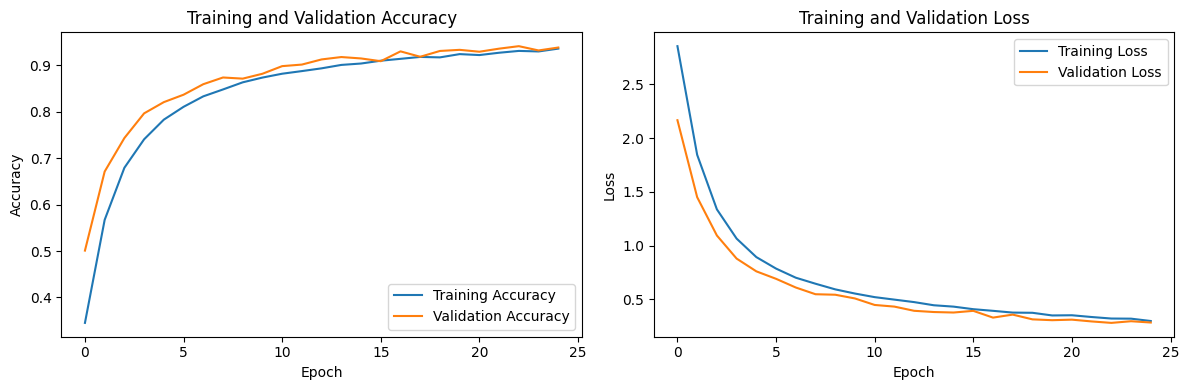

In [ ]:
import matplotlib.pyplot as plt


accuracy = HistorymodelBiLstmCNN2.history['sparse_categorical_accuracy']
loss = HistorymodelBiLstmCNN2.history['loss']
val_accuracy = HistorymodelBiLstmCNN2.history['val_sparse_categorical_accuracy']
val_loss = HistorymodelBiLstmCNN2.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# BiLSTM Glove

In [ ]:
import numpy as np
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, LSTM, Conv2D, Dropout
from keras.models import Sequential, Model
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords

In [ ]:
embedding_dictionary = dict()

glove_file = open('/content/drive/MyDrive/Experimentos/glove.6B.300d.txt', encoding='utf-8')
for linea in glove_file:
    values = linea.split()
    word = values[0]
    vector_dimensiones = np.asarray(values[1:], dtype="float32") #se obtiene el vector de pesos
    embedding_dictionary[word] = vector_dimensiones #a cada palabra se define el vector de pesos
glove_file.close()

In [ ]:
maximo_largo =300 #Este va a hacer el máximo largo de las secuencias
vocab_size = len(tokenizer.word_index) + 1
vocab_size


75255

In [ ]:
def obtener_pesos_matrix_para_cada_palabra(call_model):
    weights_matrix = np.zeros((vocab_size, maximo_largo))

    for word, index in tokenizer.word_index.items():
        embedding_vector = call_model.get(word) #se transforma y se obtiene la matriz de pesos

        if embedding_vector is not None:
            weights_matrix[index] = embedding_vector
    return weights_matrix

In [ ]:
Embeddings = obtener_pesos_matrix_para_cada_palabra(embedding_dictionary)

In [ ]:
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, Input, LeakyReLU
from keras.models import Sequential, Model


maximo_largo_secuencias=300

input_seq  = Input(shape=(maximo_largo_secuencias,), dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=maximo_largo_secuencias, weights=[Embeddings], input_length=maximo_largo_secuencias, trainable=False)(input_seq)
lstm1 = Bidirectional(LSTM(32, return_sequences=True))(embedding_layer)
dropout = Dropout(0.5)(lstm1)
lstm2 = Bidirectional(LSTM(32))(dropout)
dense = Dense(32)(lstm2)
dense = LeakyReLU(alpha=0.2)(dense)
output = Dense(7, activation="softmax")(dense)

modelBiLstmGlove = Model(inputs=input_seq, outputs=output)

modelBiLstmGlove.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

modelBiLstmGlove.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 300, 300)          22576500  
                                                                 
 bidirectional_2 (Bidirecti  (None, 300, 64)           85248     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 300, 64)           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 32)                2080

In [ ]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/Glove/BiLstm/64batch', exist_ok=True)


checkpoint_path = '/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/Glove/BiLstm/64batch/best_model_modelLSTM_{epoch}_{val_sparse_categorical_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/Glove/BiLstm/64batch', exist_ok=True)



log_dir = "/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/Glove/BiLstm/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historyGlove = modelBiLstmGlove.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint, tensorboard_callback]
)

Epoch 1/10
    758/Unknown - 83s 38ms/step - loss: 1.3986 - sparse_categorical_accuracy: 0.4738
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.55454, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/Glove/BiLstm/64batch/best_model_modelLSTM_1_0.5545.h5
759/759 [==============================] - 178s 164ms/step - loss: 1.3985 - sparse_categorical_accuracy: 0.4739 - val_loss: 1.2241 - val_sparse_categorical_accuracy: 0.5545
Epoch 2/10
759/759 [==============================] - ETA: 0s - loss: 1.1776 - sparse_categorical_accuracy: 0.5753
Epoch 2: val_sparse_categorical_accuracy improved from 0.55454 to 0.60876, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/Glove/BiLstm/64batch/best_model_modelLSTM_2_0.6088.h5
759/759 [==============================] - 134s 116ms/step - loss: 1.1776 - sparse_categorical_accuracy: 0.5753 - val_loss: 1.0912 - val_sparse_categorical_accurac

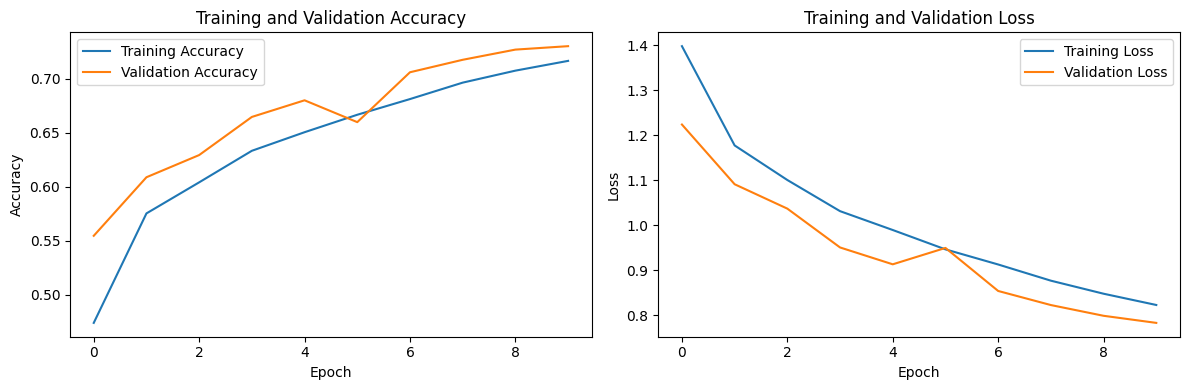

In [ ]:
import matplotlib.pyplot as plt


accuracy = historyGlove.history['sparse_categorical_accuracy']
loss = historyGlove.history['loss']
val_accuracy = historyGlove.history['val_sparse_categorical_accuracy']
val_loss = historyGlove.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# BiLSTM Word2Vec Concadenado con FastText

In [ ]:
!pip install gensim


In [ ]:
import gensim #libreria con varios embeddings como Word2Vec y FastText

In [ ]:
dataSentences = [texto.split() for texto in textLower]

In [ ]:
dataSentences

In [ ]:
DIM = 300 #maximo largo de la secuencia
maxlen=300
w2v_model = gensim.models.Word2Vec(sentences=dataSentences, vector_size=DIM, window=5, min_count=1) #Modelo pre-entrenado Word2vec
fasttext_model = gensim.models.FastText(sentences=dataSentences, vector_size=DIM, window=5, min_count=1) #Modelo pre-entrenado FastText
#Tiene que aparecer una vez como minimo en la secuencia para considerarlo

w2v_model

In [ ]:
w2v_model.wv['meaning']

array([-1.91941589e-01,  5.10859601e-02,  1.22777112e-01, -2.01106623e-01,
       -5.30879237e-02,  1.16956249e-01,  1.77523151e-01,  1.80899978e-01,
        2.22349554e-01, -1.11477911e-01,  7.64258066e-03, -1.26512527e-01,
       -1.84287772e-01, -8.21831897e-02, -1.07303180e-01,  4.79583852e-02,
        2.15037227e-01, -4.16336618e-02, -5.32070398e-02,  3.56019801e-03,
       -6.87875375e-02, -3.26733626e-02, -3.39969359e-02,  9.06137303e-02,
       -1.46133408e-01,  1.00320049e-01, -1.99737310e-01, -1.45013839e-01,
       -2.31210083e-01, -7.24602565e-02,  2.93949805e-03, -4.04013656e-02,
        2.92126089e-02, -1.35610569e-02, -1.20494351e-01, -9.30173546e-02,
       -1.95224032e-01, -2.84235477e-01,  4.26782928e-02,  3.56068879e-01,
       -9.53423902e-02,  8.85285959e-02, -1.02064125e-01, -2.47775130e-02,
        3.33055317e-01,  2.51207680e-01,  1.85524434e-01,  7.84761459e-02,
        6.19965270e-02,  9.28613394e-02,  1.67622536e-01,  2.63616559e-04,
        3.94938529e-01,  

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size


75255

In [ ]:
vocab = tokenizer.word_index
vocab

{'the': 1,
 'i': 2,
 'to': 3,
 'a': 4,
 'you': 5,
 'and': 6,
 'of': 7,
 'in': 8,
 'my': 9,
 'is': 10,
 'it': 11,
 'for': 12,
 'that': 13,
 'me': 14,
 'on': 15,
 'this': 16,
 's': 17,
 'with': 18,
 'was': 19,
 'not': 20,
 'when': 21,
 'so': 22,
 'be': 23,
 'at': 24,
 'what': 25,
 'have': 26,
 'your': 27,
 'just': 28,
 'no': 29,
 'we': 30,
 'are': 31,
 'can': 32,
 't': 33,
 'all': 34,
 'but': 35,
 'do': 36,
 'like': 37,
 'out': 38,
 'from': 39,
 'up': 40,
 'love': 41,
 'day': 42,
 'one': 43,
 'know': 44,
 'about': 45,
 'get': 46,
 'im': 47,
 'life': 48,
 'people': 49,
 'had': 50,
 'how': 51,
 'he': 52,
 'its': 53,
 'they': 54,
 'birthday': 55,
 'dont': 56,
 'time': 57,
 'by': 58,
 'as': 59,
 'good': 60,
 'if': 61,
 'now': 62,
 'an': 63,
 'who': 64,
 'go': 65,
 'there': 66,
 'oh': 67,
 'will': 68,
 'her': 69,
 'happy': 70,
 'she': 71,
 'fear': 72,
 'got': 73,
 're': 74,
 'm': 75,
 'why': 76,
 'or': 77,
 'new': 78,
 'really': 79,
 'see': 80,
 'night': 81,
 'today': 82,
 'well': 83,
 'our':

In [ ]:
import numpy as np

def get_weights_matrix_embedding_word2vec(model_w2v, fasttext_model):

    weights_matrix = np.zeros((vocab_size, DIM)) #el dim es la dimensión del modelo
    for word, index in vocab.items():
      try:
        weights_matrix[index] = model_w2v.wv[word] #obtiene los pesos de la palabra del modelo word2vec
      except KeyError:
        weights_matrix[index] = fasttext_model.wv[word] #En caso de que no exista en el vocabulario de Word2Vec ocupa FastText


    return weights_matrix

In [ ]:
#Creación del embedding, donde ingresa cada palabra al modelo y retorna los pesos
Embeddings = get_weights_matrix_embedding_word2vec(w2v_model, fasttext_model)

In [ ]:
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, Input, LeakyReLU, Dropout
from keras.models import Sequential, Model


maximo_largo_secuencias=300

input_seq  = Input(shape=(maximo_largo_secuencias,), dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=maximo_largo_secuencias, weights=[Embeddings], input_length=maximo_largo_secuencias, trainable=False)(input_seq)
lstm1 = Bidirectional(LSTM(32, return_sequences=True))(embedding_layer)
dropout = Dropout(0.5)(lstm1)
lstm2 = Bidirectional(LSTM(32))(dropout)
dense = Dense(32)(lstm2)
dense = LeakyReLU(alpha=0.2)(dense)
output = Dense(7, activation="softmax")(dense)

modelBiLstmWord2Vec = Model(inputs=input_seq, outputs=output)

modelBiLstmWord2Vec.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

modelBiLstmWord2Vec.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 300, 300)          22576500  
                                                                 
 bidirectional_1 (Bidirecti  (None, 300, 64)           85248     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 300, 64)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 32)                2080  

In [ ]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/Word2VecConcadenadoFastText/BiLstm/64batch', exist_ok=True)


checkpoint_path = '/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/Word2VecConcadenadoFastText/BiLstm/64batch/best_model_modelLSTM_{epoch}_{val_sparse_categorical_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/Word2VecConcadenadoFastText/BiLstm/64batch', exist_ok=True)



log_dir = "/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/Word2VecConcadenadoFastText/BiLstm/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historyWord2Vec = modelBiLstmWord2Vec.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint, tensorboard_callback]
)

Epoch 1/10
    759/Unknown - 85s 39ms/step - loss: 1.4376 - sparse_categorical_accuracy: 0.4542
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.51779, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/Word2VecConcadenadoFastText/BiLstm/64batch/best_model_modelLSTM_1_0.5178.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


759/759 [==============================] - 144s 117ms/step - loss: 1.4376 - sparse_categorical_accuracy: 0.4542 - val_loss: 1.2919 - val_sparse_categorical_accuracy: 0.5178
Epoch 2/10
758/759 [============================>.] - ETA: 0s - loss: 1.2888 - sparse_categorical_accuracy: 0.5181
Epoch 2: val_sparse_categorical_accuracy improved from 0.51779 to 0.54319, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/Word2VecConcadenadoFastText/BiLstm/64batch/best_model_modelLSTM_2_0.5432.h5
759/759 [==============================] - 132s 113ms/step - loss: 1.2888 - sparse_categorical_accuracy: 0.5180 - val_loss: 1.2260 - val_sparse_categorical_accuracy: 0.5432
Epoch 3/10
758/759 [============================>.] - ETA: 0s - loss: 1.2276 - sparse_categorical_accuracy: 0.5451
Epoch 3: val_sparse_categorical_accuracy improved from 0.54319 to 0.56879, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/

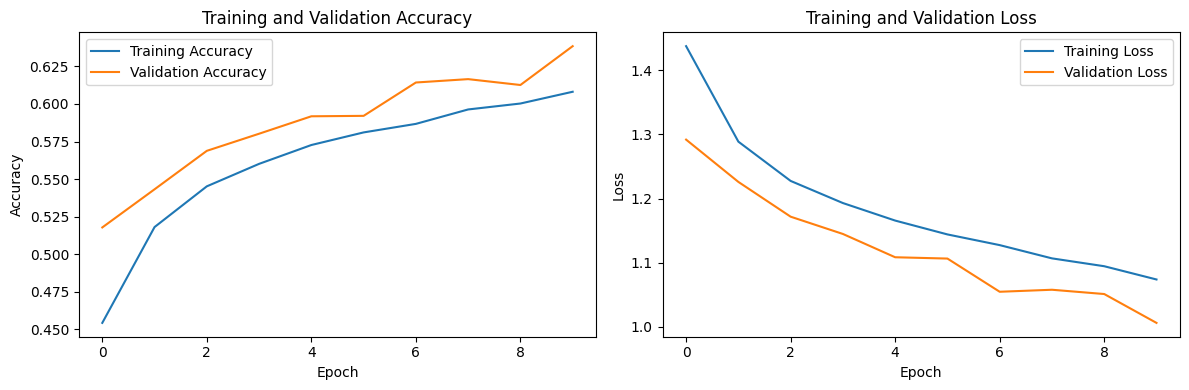

In [ ]:
import matplotlib.pyplot as plt


accuracy = historyWord2Vec.history['sparse_categorical_accuracy']
loss = historyWord2Vec.history['loss']
val_accuracy = historyWord2Vec.history['val_sparse_categorical_accuracy']
val_loss = historyWord2Vec.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# BILSTM Con Word2Vec y FastText

In [ ]:
!pip install gensim

In [ ]:
import gensim #libreria con varios embeddings como Word2Vec y FastText

In [ ]:
dataSentences = [texto.split() for texto in textLower]

In [ ]:
DIM = 300
maxlen=300
w2v_model = gensim.models.Word2Vec(sentences=dataSentences, vector_size=DIM, window=5, min_count=1)
fasText_model = gensim.models.FastText(sentences=dataSentences, vector_size=DIM, window=5, min_count=1)
#Llamada a Embeddings pre-entrenados de la libreria gensim

w2v_model

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

75255

In [ ]:
vocab = tokenizer.word_index
vocab

{'the': 1,
 'i': 2,
 'to': 3,
 'a': 4,
 'you': 5,
 'and': 6,
 'of': 7,
 'in': 8,
 'my': 9,
 'is': 10,
 'it': 11,
 'for': 12,
 'that': 13,
 'me': 14,
 'on': 15,
 'this': 16,
 's': 17,
 'with': 18,
 'was': 19,
 'not': 20,
 'when': 21,
 'so': 22,
 'be': 23,
 'at': 24,
 'what': 25,
 'have': 26,
 'your': 27,
 'just': 28,
 'no': 29,
 'we': 30,
 'are': 31,
 'can': 32,
 't': 33,
 'all': 34,
 'but': 35,
 'do': 36,
 'like': 37,
 'out': 38,
 'from': 39,
 'up': 40,
 'love': 41,
 'day': 42,
 'one': 43,
 'know': 44,
 'about': 45,
 'get': 46,
 'im': 47,
 'life': 48,
 'people': 49,
 'had': 50,
 'how': 51,
 'he': 52,
 'its': 53,
 'they': 54,
 'birthday': 55,
 'dont': 56,
 'time': 57,
 'by': 58,
 'as': 59,
 'good': 60,
 'if': 61,
 'now': 62,
 'an': 63,
 'who': 64,
 'go': 65,
 'there': 66,
 'oh': 67,
 'will': 68,
 'her': 69,
 'happy': 70,
 'she': 71,
 'fear': 72,
 'got': 73,
 're': 74,
 'm': 75,
 'why': 76,
 'or': 77,
 'new': 78,
 'really': 79,
 'see': 80,
 'night': 81,
 'today': 82,
 'well': 83,
 'our':

In [ ]:
import numpy as np

def get_weights_matrix_embedding_word2vecFastText(model_w2v, fasttext_model):

    weights_matrix = np.zeros((vocab_size, DIM)) #el dim es la dimensión del modelo
    for word, index in vocab.items():
      try:
        weights_matrix[index] = model_w2v.wv[word] #obtiene los pesos de la palabra del modelo word2vec
      except KeyError:
        weights_matrix[index] = fasttext_model.wv[word] #en caso de no estar en el vocabulario de word2Vec ocupa FastText


    return weights_matrix


def get_weights_matrix_embedding(model):
    weights_matrix = np.zeros((vocab_size, DIM)) #el dim es la dimensión del modelo

    for word, index in vocab.items():
        weights_matrix[index] = model.wv[word] #obtiene los pesos de la palabra del modelo wor2vec

    return weights_matrix

In [ ]:
#Creación del embedding, donde ingresa cada palabra al modelo y retorna los pesos
EmbeddingsW2Vec = get_weights_matrix_embedding_word2vecFastText(w2v_model, fasText_model) #Pesos para Word2Vec con complemento de FastText
EmbeddingsFastText = get_weights_matrix_embedding(fasText_model) #Pesos para FastText

In [ ]:
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, Input, LeakyReLU, concatenate, Dropout
from keras.models import Sequential, Model


maximo_largo_secuencias=300

input_seq  = Input(shape=(maximo_largo_secuencias,), dtype='int32')
embedding_word2vec = Embedding(input_dim=vocab_size, output_dim=maximo_largo_secuencias, weights=[EmbeddingsW2Vec], input_length=maximo_largo_secuencias, trainable=False)(input_seq)
embedding_fasttext = Embedding(input_dim=vocab_size, output_dim=maximo_largo_secuencias, weights=[EmbeddingsFastText], input_length=maximo_largo_secuencias, trainable=False)(input_seq)

lstm_word2vec = Bidirectional(LSTM(32))(embedding_word2vec)
dropout_word2vec = Dropout(0.5)(lstm_word2vec)

lstm_fasttext = Bidirectional(LSTM(32))(embedding_fasttext)
dropout_fastText = Dropout(0.5)(lstm_fasttext)


concatenated = concatenate([dropout_word2vec, dropout_fastText])

dense = Dense(32)(concatenated)
dense = LeakyReLU(alpha=0.2)(dense)
output = Dense(7, activation="softmax")(dense)

modelBiLstmWord2VecFastText = Model(inputs=input_seq, outputs=output)

modelBiLstmWord2VecFastText.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

modelBiLstmWord2VecFastText.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 300, 300)             2257650   ['input_2[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_3 (Embedding)     (None, 300, 300)             2257650   ['input_2[0][0]']             
                                                          0                                       
                                                                                              

In [ ]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/Word2VecFastTextSeparadoEmbedding/BiLstm/64batch', exist_ok=True)


checkpoint_path = '/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/Word2VecFastTextSeparadoEmbedding/BiLstm/64batch/best_model_modelLSTM_{epoch}_{val_sparse_categorical_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/Word2VecFastTextSeparadoEmbedding/BiLstm/64batch', exist_ok=True)



log_dir = "/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/Word2VecFastTextSeparadoEmbedding/BiLstm/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
historyWord2VecFastText = modelBiLstmWord2VecFastText.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint, tensorboard_callback]
)

Epoch 1/10
    758/Unknown - 95s 42ms/step - loss: 1.5085 - sparse_categorical_accuracy: 0.4217
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.49711, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/Word2VecFastTextSeparadoEmbedding/BiLstm/64batch/best_model_modelLSTM_1_0.4971.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


759/759 [==============================] - 160s 128ms/step - loss: 1.5085 - sparse_categorical_accuracy: 0.4217 - val_loss: 1.3274 - val_sparse_categorical_accuracy: 0.4971
Epoch 2/10
758/759 [============================>.] - ETA: 0s - loss: 1.3629 - sparse_categorical_accuracy: 0.4872
Epoch 2: val_sparse_categorical_accuracy improved from 0.49711 to 0.53414, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/Word2VecFastTextSeparadoEmbedding/BiLstm/64batch/best_model_modelLSTM_2_0.5341.h5
759/759 [==============================] - 175s 169ms/step - loss: 1.3629 - sparse_categorical_accuracy: 0.4873 - val_loss: 1.2628 - val_sparse_categorical_accuracy: 0.5341
Epoch 3/10
759/759 [==============================] - ETA: 0s - loss: 1.3208 - sparse_categorical_accuracy: 0.5084
Epoch 3: val_sparse_categorical_accuracy improved from 0.53414 to 0.54206, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmB

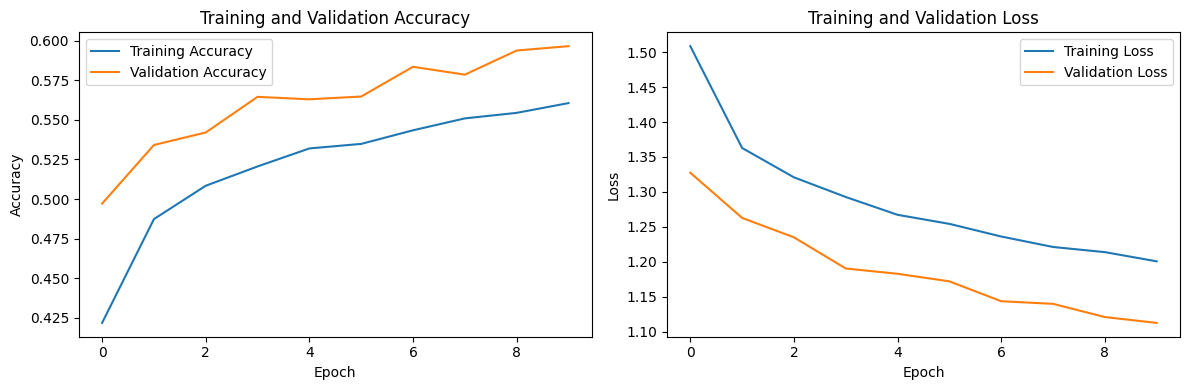

In [ ]:
import matplotlib.pyplot as plt


accuracy = historyWord2VecFastText.history['sparse_categorical_accuracy']
loss = historyWord2VecFastText.history['loss']
val_accuracy = historyWord2VecFastText.history['val_sparse_categorical_accuracy']
val_loss = historyWord2VecFastText.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# BERT

### Tokenizador

In [22]:
FullTokenizer = bert.bert_tokenization.FullTokenizer #llamada a la instancia de bert libreria para obtener la tokenización.



#Llamado al modelo pre-entrenado de Bert L-12
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1", trainable=False)


#obtener el vocabulario del Hub de bert
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

#transformación a minusculas
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

#aplicación al tokenizador mediante el vocabulario y transformando las palabras a minusculas
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [23]:
#Función para aplicar el token en cada sentencia
def encode_sentence(sent):
  return ["[CLS]"] + tokenizer.tokenize(sent) + ["[SEP]"]
  #Se aplica CLS para el inicio de clasificación y SEP para la separación en cada secuencia. Esto lo pide Bert.

In [24]:
#Llamada a la función que convierte en tokens
data_inputs = [encode_sentence(sentence) for sentence in texto_clean]

In [ ]:
data_inputs

[['[CLS]',
  'also',
  'I',
  'was',
  'the',
  'point',
  'person',
  'on',
  'my',
  'company',
  's',
  'transition',
  'from',
  'the',
  'K',
  '##L',
  'to',
  'G',
  '##R',
  'system',
  '.',
  '[SEP]'],
 ['[CLS]', 'You', 'must', 've', 'had', 'your', 'hands', 'full', '.', '[SEP]'],
 ['[CLS]', 'That', 'I', 'did', '.', 'That', 'I', 'did', '.', '[SEP]'],
 ['[CLS]',
  'So',
  'let',
  's',
  'talk',
  'a',
  'little',
  'bit',
  'about',
  'your',
  'duties',
  '.',
  '[SEP]'],
 ['[CLS]', 'My', 'duties', '?', 'All', 'right', '.', '[SEP]'],
 ['[CLS]',
  'Now',
  'you',
  'll',
  'be',
  'heading',
  'a',
  'whole',
  'division',
  'so',
  'you',
  'll',
  'have',
  'a',
  'lot',
  'of',
  'duties',
  '.',
  '[SEP]'],
 ['[CLS]', 'I', 'see', '.', '[SEP]'],
 ['[CLS]',
  'But',
  'there',
  'll',
  'be',
  'perhaps',
  'people',
  'under',
  'you',
  'so',
  'you',
  'can',
  'dump',
  'a',
  'certain',
  'amount',
  'on',
  'them',
  '.',
  '[SEP]'],
 ['[CLS]', 'Good', 'to', 'know', '.'

In [25]:
#Transforma los tokens en lista de ids para obtener la forma numerica de los datos
def get_ids(tokens):
  return tokenizer.convert_tokens_to_ids(tokens)



#Se aplica la mascara para eliminar los tokens de PAD que son los padding para igualar los valores, igualando el token PAD en 0
def get_mask(tokens):
  return np.char.not_equal(tokens, "[PAD]").astype(int)


#Indica si el token es de la primera frase o segunda fase, agrando 0 o 1 dependiendo de la separación
def get_segments(tokens):
  seg_ids = [] #es una lista que se rellena con el token
  current_seg_ids = 0

  for tok in tokens: #recorre todos los tokens
    seg_ids.append(current_seg_ids)
    if tok == "[SEP]": #si el token es de separación
      current_seg_ids = 1-current_seg_ids #convierte los 1 en 0 y viceversa

  return seg_ids

## Preparación y creación del dataset

In [26]:
import random

#Se crea una lista mediante la secuencia, su respectivo label y el largo de la frase.
data_with_len = [[sent, data_labels[i], len(sent)]
                 for i, sent in enumerate(data_inputs)]

#Se mezcla los datos de forma aleatoria
random.shuffle(data_with_len)

#Ordena los datos segun el largo de la secuencia obtenida mediante el len(sent) de la segunda posición
data_with_len.sort(key=lambda x: x[2])

#Se genera una tupla, se entrega la secuencia para obtener las ids, mask y segments, Además se agrega el label de la secuencia.
sorted_all = [([get_ids(sent_lab[0]),
                get_mask(sent_lab[0]),
                get_segments(sent_lab[0])],
               sent_lab[1])
               for sent_lab in data_with_len]

In [ ]:
len(sorted_all) #En total son 138.607 datos

138607

In [27]:
# Creación del generador, mediante la entrega de la tupla de los datos.
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all,
                                             output_types=(tf.int32, tf.int32)) #La salida es entera de tuplas de los datos transformados int(texto), int(etiqueta)


In [ ]:
all_dataset

<_FlatMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [ ]:
# Mostrar una iteración
next(iter(all_dataset))


(<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
 array([[101, 102],
        [  1,   1],
        [  0,   0]], dtype=int32)>,
 <tf.Tensor: shape=(), dtype=int32, numpy=4>)

## Aplicar padding variable

In [28]:
#Se aplica al iterador el batch para cada entrega de datos y se aplica un padding variable, donde se rellena de valores de 0
BATCH_SIZE = 64
all_batched = all_dataset.padded_batch(BATCH_SIZE,
                                       padded_shapes=((3, None), ()),
                                       padding_values=(0, 0))

In [ ]:
# Mostrar batch:
next(iter(all_batched))

(<tf.Tensor: shape=(64, 3, 3), dtype=int32, numpy=
 array([[[  101,   102,     0],
         [    1,     1,     0],
         [    0,     0,     0]],
 
        [[  101,   102,     0],
         [    1,     1,     0],
         [    0,     0,     0]],
 
        [[  101,   102,     0],
         [    1,     1,     0],
         [    0,     0,     0]],
 
        [[  101,   102,     0],
         [    1,     1,     0],
         [    0,     0,     0]],
 
        [[  101,   102,     0],
         [    1,     1,     0],
         [    0,     0,     0]],
 
        [[  101,   102,     0],
         [    1,     1,     0],
         [    0,     0,     0]],
 
        [[  101,  1262,   102],
         [    1,     1,     1],
         [    0,     0,     0]],
 
        [[  101, 19465,   102],
         [    1,     1,     1],
         [    0,     0,     0]],
 
        [[  101,  1262,   102],
         [    1,     1,     1],
         [    0,     0,     0]],
 
        [[  101,  3956,   102],
         [    1,     1,   

## División de batches para entrenamiento, testeo y validación

In [29]:

import math

# Calcular el número total de lotes
NB_BATCHES = math.ceil(len(sorted_all) / BATCH_SIZE)
print("NB_BATCHES totales: ",NB_BATCHES)

# Calcular el número de lotes para validación y prueba
NB_BATCHES_VAL = (NB_BATCHES * 20) // 100
NB_BATCHES_TEST = (NB_BATCHES * 10) // 100
print("NB_BATCHES validacion: ",NB_BATCHES_VAL)
print("NB_BATCHES testeo: ",NB_BATCHES_TEST)
print("NB_BATCHES entrenamiento", NB_BATCHES - (NB_BATCHES_TEST + NB_BATCHES_VAL))


# Mezclar el conjunto de datos
all_batched = all_batched.shuffle(NB_BATCHES)

# Crear conjuntos de datos para entrenamiento, validación y prueba
val_dataset = all_batched.take(NB_BATCHES_VAL)
train_dataset = all_batched.skip(NB_BATCHES_VAL).skip(NB_BATCHES_TEST).take(NB_BATCHES - (NB_BATCHES_TEST + NB_BATCHES_VAL)) #Solo toma el N de batches - conjunto de test- conjunto de val
test_dataset = all_batched.skip(NB_BATCHES_VAL).take(NB_BATCHES_TEST)

NB_BATCHES totales:  2166
NB_BATCHES validacion:  433
NB_BATCHES testeo:  216
NB_BATCHES entrenamiento 1517


In [ ]:
num_batches_train = 0
for _ in train_dataset:
    num_batches_train += 1
    print(num_batches_train)
print("Número de lotes en train_dataset:", num_batches_train)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


## Modelo 1- Bert CNN

Se aplica el modelo Bert + capas convolucionales mediante la arquitectura N-gram

In [ ]:
class DCNNBERTEmbedding(tf.keras.Model):


    def __init__(self,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=7,
                 dropout_rate=0.1,
                 name="dcnn"):
        super(DCNNBERTEmbedding, self).__init__(name=name)

        #Capa de embedding de Bert
        self.bert_layer = hub.KerasLayer(
            "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",
            trainable=False)

        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="same",
                                    activation="relu") #Segunda capa mediante un kernel size de 2
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="same",
                                     activation="relu") #Tercera capa mediante un kernel size de 3
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="same",
                                      activation="relu") #Cuarta capa mediante un kernel size de 4
        self.pool = layers.GlobalMaxPool1D()
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)

        self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")


    #Función para entregar la entrada al Embedding, donde se entrega hacia el ids, mask y segments creados anteriormente.
    def embed_with_bert(self, all_tokens):
        _, embs = self.bert_layer([all_tokens[:, 0, :],
                                   all_tokens[:, 1, :],
                                   all_tokens[:, 2, :]])
        return embs

    def call(self, inputs, training):
        x = self.embed_with_bert(inputs) #aqui se llama al embedding y se entrega la entrada

        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)

        merged = tf.concat([x_1, x_2, x_3], axis=-1) #Se concadenan las convoluciones
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)

        return output

In [ ]:
#Hiperparametros
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 7

DROPOUT_RATE = 0.2

NB_EPOCHS = 5
BATCH_SIZE=32

In [ ]:
Dcnn = DCNNBERTEmbedding(nb_filters=NB_FILTERS,
                         FFN_units=FFN_UNITS,
                         nb_classes=NB_CLASSES,
                         dropout_rate=DROPOUT_RATE)


In [ ]:
Dcnn.compile(loss="sparse_categorical_crossentropy", #Sparse, debido que los datos no se le aplico One-hot
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [ ]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BERT/CNN/64batch', exist_ok=True)


checkpoint_path = '/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BERT/CNN/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='tf',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/BERT/CNN/64batch', exist_ok=True)



log_dir = "/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/BERT/CNN/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
history = Dcnn.fit(train_dataset,
         epochs=25,
         validation_data=val_dataset,
         callbacks = [model_checkpoint, tensorboard_callback])

Epoch 1/25
   1517/Unknown - 213s 112ms/step - loss: 1.1646 - sparse_categorical_accuracy: 0.5678
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.66072, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BERT/CNN/64batch/BERT_CNN_model_best_01_val_0.6607
1517/1517 [==============================] - 322s 184ms/step - loss: 1.1646 - sparse_categorical_accuracy: 0.5678 - val_loss: 0.9409 - val_sparse_categorical_accuracy: 0.6607
Epoch 2/25
1517/1517 [==============================] - ETA: 0s - loss: 0.9120 - sparse_categorical_accuracy: 0.6723
Epoch 2: val_sparse_categorical_accuracy improved from 0.66072 to 0.75097, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BERT/CNN/64batch/BERT_CNN_model_best_02_val_0.7510
1517/1517 [==============================] - 295s 178ms/step - loss: 0.9120 - sparse_categorical_accuracy: 0.6723 - val_loss: 0.7126 - val_sparse_categorical_accur

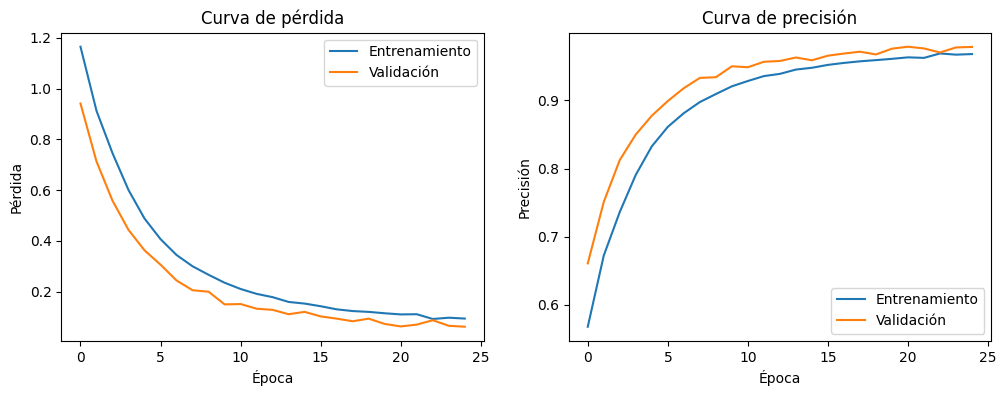

In [ ]:
import matplotlib.pyplot as plt


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [ ]:
modelDCNN = load_model('/content/drive/MyDrive/Tesis avance/Modelos descargar hasta el momento/BERT_CNN_model_best_21_val_0.9787')
modelDCNN.summary()

Model: "dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  multiple                  108310273 
                                                                 
 conv1d_3 (Conv1D)           multiple                  153700    
                                                                 
 conv1d_4 (Conv1D)           multiple                  230500    
                                                                 
 conv1d_5 (Conv1D)           multiple                  307300    
                                                                 
 global_max_pooling1d_1 (Gl  multiple                  0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             multiple                  77056     
                                                              

### Análisis de reporte de clasificación para visualizar métricas

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

In [ ]:

# Almacenar las etiquetas reales y el texto de cada etiqueta
texts = []
y_true = []

# Obtener los datos reales
for text_batch, label_batch in test_dataset:
    for text in text_batch.numpy():
        text_decoded = text.decode('utf-8') if isinstance(text, bytes) else text
        texts.append([text_decoded])
    y_true.extend(label_batch.numpy())


y_true = np.array(y_true)

# Almacenar las etiquetas predichas
y_pred_classes = []


# Obtener los datos predichos mediante la entrega del texto obtenido
for text_list in texts:
    text = text_list[0]
    predictions = Dcnn(tf.constant([text]), training=False)  # Se convierte a tensor para poder ingresar al modelo
    predicted_class = tf.argmax(predictions, axis=1).numpy()[0]
    y_pred_classes.append(predicted_class)



y_pred_classes = np.array(y_pred_classes)


# Informe de clasificación
report = classification_report(y_true, y_pred_classes)
print(report)



              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1945
           1       0.99      0.99      0.99      1934
           2       0.99      0.99      0.99      2014
           3       0.98      0.98      0.98      1970
           4       0.99      0.98      0.99      2047
           5       0.99      0.96      0.97      1960
           6       0.96      0.99      0.97      1954

    accuracy                           0.98     13824
   macro avg       0.98      0.98      0.98     13824
weighted avg       0.98      0.98      0.98     13824



### Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Text(95.72222222222221, 0.5, 'True labels')

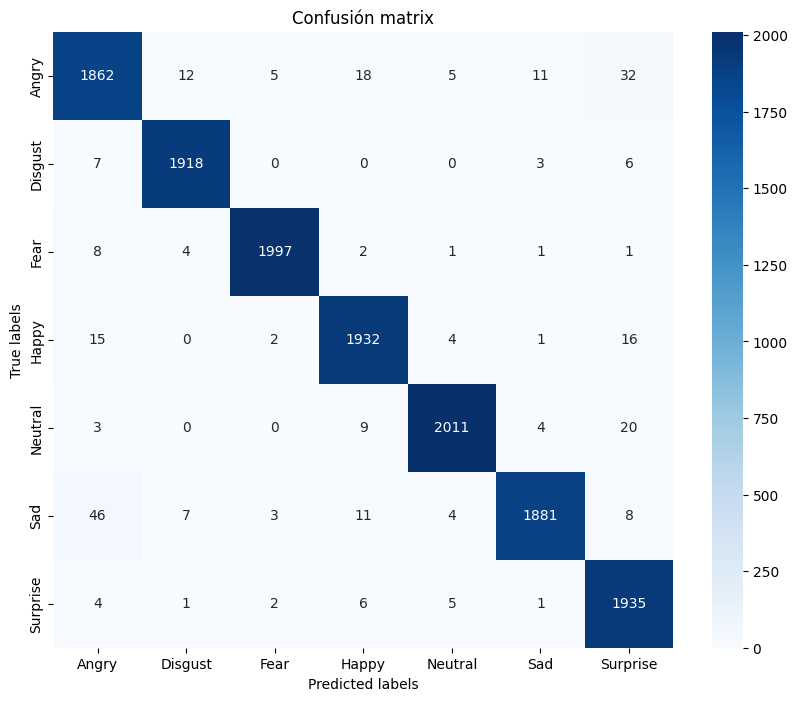

In [ ]:
confusion_ma=  confusion_matrix(y_true, y_pred_classes)


clases = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

plt.figure(figsize=(10,8))
sns.heatmap(confusion_ma, annot=True, fmt='d', cmap='Blues', xticklabels =clases , yticklabels=clases)
plt.title('Confusión matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

### Accuracy conjunto de testeo

In [ ]:
result = Dcnn.evaluate(test_dataset)
print("Test conjunto de prueba:", result)

216/216 [==============================] - 55s 93ms/step - loss: 0.0556 - sparse_categorical_accuracy: 0.9816
Test conjunto de prueba: [0.055621132254600525, 0.9815537929534912]


## Modelo 2- Bert BILSTM

Se aplica el modelo Bert + capas BiLSTM

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

class BertBiLSTM(tf.keras.Model):
    def __init__(self,
                 nb_classes=7,
                 dropout_rate=0.1,
                 name="bert_bilstm"):
        super(BertBiLSTM, self).__init__(name=name)

        #Capa de embedding de Bert
        self.bert_layer = hub.KerasLayer(
            "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
            trainable=False)

        # Capas BiLSTM
        self.bilstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True))
        self.bilstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True))

        # Capa de GlobalAveragePooling1D
        self.global_average = tf.keras.layers.GlobalAveragePooling1D()

        # Capas densas
        self.dense_1 = tf.keras.layers.Dense(units=512, activation="relu")
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = tf.keras.layers.Dense(units=1, activation="sigmoid")
        else:
            self.last_dense = tf.keras.layers.Dense(units=nb_classes, activation="softmax")

    # Función para obtener los embeddings de BERT
    def embed_with_bert(self, all_tokens):
        _, embs = self.bert_layer([all_tokens[:, 0, :],
                                   all_tokens[:, 1, :],
                                   all_tokens[:, 2, :]])
        return embs

    def call(self, inputs, training):
        x = self.embed_with_bert(inputs)  # Embeddings de BERT y se entrega la entrada

        # Aplicar BiLSTM
        x = self.bilstm1(x)
        x = self.bilstm2(x)

         # Aplicar GlobalAveragePooling1D
        x = self.global_average(x)

        # Capas densas y dropout
        x = self.dense_1(x)
        x = self.dropout(x, training = training)
        output = self.last_dense(x)

        return output

In [ ]:
#Hiperparametros
FFN = 512
CLASSES = 7
RATE = 0.1

BertBiLSTM = BertBiLSTM(
                        nb_classes = CLASSES,
                        dropout_rate= RATE)

BertBiLSTM.compile(loss="sparse_categorical_crossentropy", #Sparse, debido que los datos no se le aplico One-hot
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [ ]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BERT/BiLSTM/64batch', exist_ok=True)

checkpoint_path = '/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BERT/BiLSTM/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='tf',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/BERT/BiLSTM/64batch', exist_ok=True)


log_dir = "/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/BERT/BiLSTM/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
historyBilstm = BertBiLSTM.fit(train_dataset,
         epochs=25,
         validation_data=val_dataset,
         callbacks = [model_checkpoint, tensorboard_callback])

Epoch 1/25
   1517/Unknown - 201s 98ms/step - loss: 1.6303 - sparse_categorical_accuracy: 0.3538
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.42891, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BERT/BiLSTM/64batch/BERT_CNN_model_best_01_val_0.4289
1517/1517 [==============================] - 326s 181ms/step - loss: 1.6303 - sparse_categorical_accuracy: 0.3538 - val_loss: 1.4851 - val_sparse_categorical_accuracy: 0.4289
Epoch 2/25
1517/1517 [==============================] - ETA: 0s - loss: 1.4346 - sparse_categorical_accuracy: 0.4487
Epoch 2: val_sparse_categorical_accuracy improved from 0.42891 to 0.49374, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BERT/BiLSTM/64batch/BERT_CNN_model_best_02_val_0.4937
1517/1517 [==============================] - 295s 177ms/step - loss: 1.4346 - sparse_categorical_accuracy: 0.4487 - val_loss: 1.3230 - val_sparse_categorical_

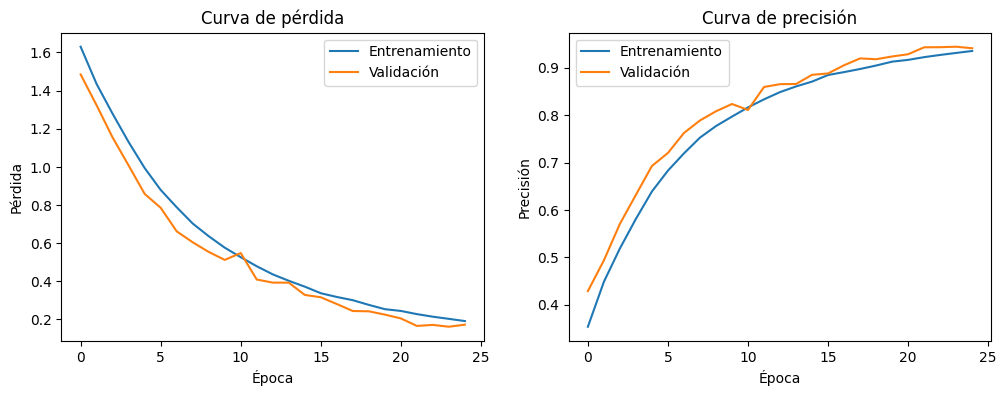

In [ ]:
import matplotlib.pyplot as plt

train_loss = historyBilstm.history['loss']
val_loss = historyBilstm.history['val_loss']
train_accuracy = historyBilstm.history['sparse_categorical_accuracy']
val_accuracy = historyBilstm.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Análisis de reporte de clasificación para visualizar métricas

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# Almacenar las etiquetas reales y el texto de cada etiqueta
texts = []
y_true = []

# Obtener los datos reales
for text_batch, label_batch in test_dataset:
    for text in text_batch.numpy():
        text_decoded = text.decode('utf-8') if isinstance(text, bytes) else text
        texts.append([text_decoded])
    y_true.extend(label_batch.numpy())


y_true = np.array(y_true)

# Almacenar las etiquetas predichas
y_pred_classes = []


# Obtener los datos predichos mediante la entrega del texto obtenido
for text_list in texts:
    text = text_list[0]
    predictions = BertBiLSTM(tf.constant([text]), training=False)  # Se convierte a tensor para poder ingresar al modelo
    predicted_class = tf.argmax(predictions, axis=1).numpy()[0]
    y_pred_classes.append(predicted_class)



y_pred_classes = np.array(y_pred_classes)

# Informe de clasificación
report = classification_report(y_true, y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1965
           1       0.96      0.96      0.96      1862
           2       0.98      0.97      0.97      1947
           3       0.98      0.89      0.94      1937
           4       0.96      0.99      0.97      2181
           5       0.94      0.95      0.94      1931
           6       0.96      0.96      0.96      1984

    accuracy                           0.95     13807
   macro avg       0.95      0.95      0.95     13807
weighted avg       0.95      0.95      0.95     13807



Text(95.72222222222221, 0.5, 'True labels')

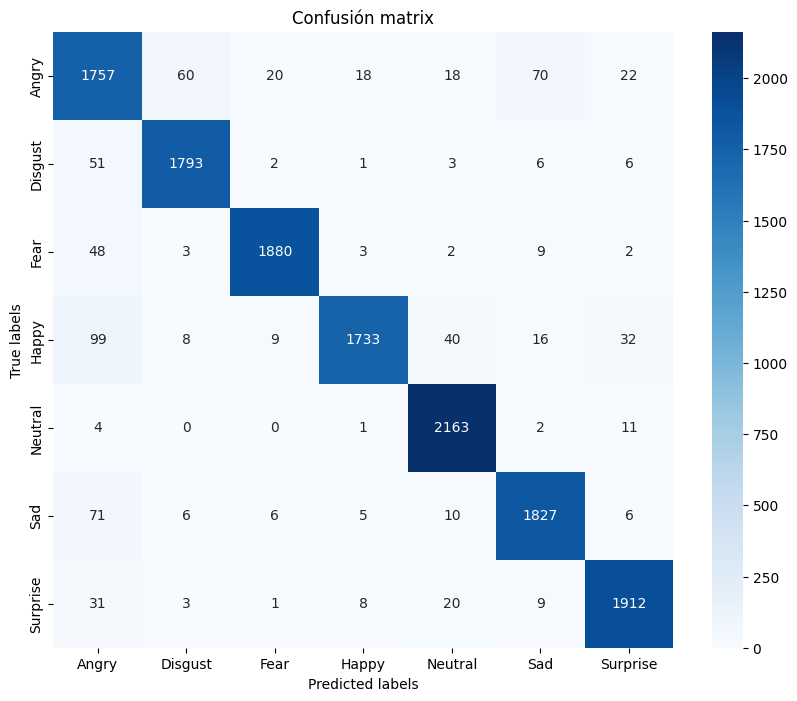

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


confusion_ma=  confusion_matrix(y_true, y_pred_classes)


clases = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

plt.figure(figsize=(10,8))
sns.heatmap(confusion_ma, annot=True, fmt='d', cmap='Blues', xticklabels =clases , yticklabels=clases)
plt.title('Confusión matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

### Accuracy conjunto de testeo

In [ ]:
results = BertBiLSTM.evaluate(test_dataset)
print(results)

216/216 [==============================] - 47s 101ms/step - loss: 0.1588 - sparse_categorical_accuracy: 0.9484
[0.15880249440670013, 0.9484230279922485]


## Modelo 3 Paper replicación

In [30]:
class CNNBERTPaper(tf.keras.Model):


    def __init__(self,
                 nb_filters_up = 100,
                 nb_classes=7,
                 dropout_rate=0.5,
                 name="dcnn"):
        super(CNNBERTPaper, self).__init__(name=name)

        #Capa de embedding de Bert
        self.bert_layer = hub.KerasLayer(
            "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",
            trainable=False)

        self.Conv1Up = layers.Conv1D(filters=nb_filters_up,
                                    kernel_size=3,
                                    padding="same",
                                    activation="relu") #Segunda capa mediante un kernel size de 2
        self.Conv2Up = layers.Conv1D(filters=nb_filters_up,
                                     kernel_size=4,
                                     padding="same",
                                     activation="relu") #Tercera capa mediante un kernel size de 3
        self.Conv3Up = layers.Conv1D(filters=nb_filters_up,
                                     kernel_size=5,
                                     padding="same",
                                     activation="relu") #Tercera capa mediante un kernel size de 3
        self.pool = layers.GlobalMaxPool1D()
        self.dropout = layers.Dropout(rate=dropout_rate)

        self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")


    #Función para entregar la entrada al Embedding, donde se entrega hacia el ids, mask y segments creados anteriormente.
    def embed_with_bert(self, all_tokens):
        _, embs = self.bert_layer([all_tokens[:, 0, :],
                                   all_tokens[:, 1, :],
                                   all_tokens[:, 2, :]])
        return embs

    def call(self, inputs, training):
        x = self.embed_with_bert(inputs) #aqui se llama al embedding y se entrega la entrada

        x_1 = self.Conv1Up(x)
        x_1 = self.pool(x_1)
        x_2 = self.Conv2Up(x)
        x_2 = self.pool(x_2)
        x_3 = self.Conv3Up(x)
        x_3 = self.pool(x_3)

        merged = tf.concat([x_1, x_2, x_3], axis=-1) #Se concadenan las convoluciones
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)

        return output

In [31]:
#Hiperparametros
NB_FILTERS_UP = 100
NB_CLASSES = 7
DROPOUT_RANGE = 0.5
LEARNING_RATE = 4e-5
EPOCHS=10

CNNBERTPaperModel = CNNBERTPaper(nb_filters_up = NB_FILTERS_UP, nb_classes= NB_CLASSES,dropout_rate = DROPOUT_RANGE)

In [32]:
from keras.optimizers import Adam

CNNBERTPaperModel.compile(loss="sparse_categorical_crossentropy", #Sparse, debido que los datos no se le aplico One-hot
                 optimizer=Adam(LEARNING_RATE),
                 metrics=["sparse_categorical_accuracy"])

### Con 16 batch

In [ ]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BERT/PAPERCNN/16batch', exist_ok=True)

checkpoint_path = '/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BERT/PAPERCNN/16batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='tf',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/BERT/PAPERCNN/16batch', exist_ok=True)


log_dir = "/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/BERT/PAPERCNN/16batch" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historyCNNBERTPAPER = CNNBERTPaperModel.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs = EPOCHS,
    callbacks = [model_checkpoint, tensorboard_callback]
)

Epoch 1/10
   1517/Unknown - 220s 118ms/step - loss: 1.5670 - sparse_categorical_accuracy: 0.4260
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.56492, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BERT/PAPERCNN/16batch/BERT_CNN_model_best_01_val_0.5649
1517/1517 [==============================] - 328s 189ms/step - loss: 1.5670 - sparse_categorical_accuracy: 0.4260 - val_loss: 1.2042 - val_sparse_categorical_accuracy: 0.5649
Epoch 2/10
1517/1517 [==============================] - ETA: 0s - loss: 1.2392 - sparse_categorical_accuracy: 0.5385
Epoch 2: val_sparse_categorical_accuracy improved from 0.56492 to 0.59667, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BERT/PAPERCNN/16batch/BERT_CNN_model_best_02_val_0.5967
1517/1517 [==============================] - 280s 168ms/step - loss: 1.2392 - sparse_categorical_accuracy: 0.5385 - val_loss: 1.1154 - val_sparse_categor

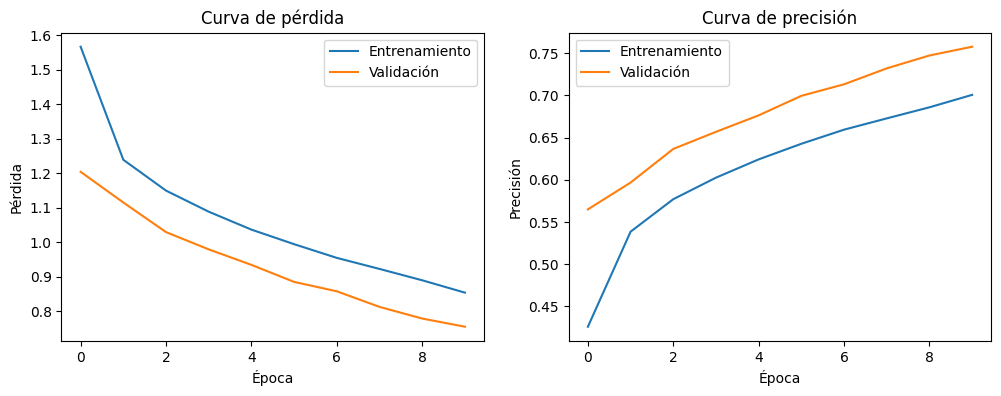

In [ ]:
import matplotlib.pyplot as plt

train_loss = historyCNNBERTPAPER.history['loss']
val_loss = historyCNNBERTPAPER.history['val_loss']
train_accuracy = historyCNNBERTPAPER.history['sparse_categorical_accuracy']
val_accuracy = historyCNNBERTPAPER.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Con 64 batch

In [33]:
class CNNBERTPaper(tf.keras.Model):


    def __init__(self,
                 nb_filters_up = 100,
                 nb_classes=7,
                 dropout_rate=0.5,
                 name="dcnn"):
        super(CNNBERTPaper, self).__init__(name=name)

        #Capa de embedding de Bert
        self.bert_layer = hub.KerasLayer(
            "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",
            trainable=False)

        self.Conv1Up = layers.Conv1D(filters=nb_filters_up,
                                    kernel_size=3,
                                    padding="same",
                                    activation="relu") #Segunda capa mediante un kernel size de 2
        self.Conv2Up = layers.Conv1D(filters=nb_filters_up,
                                     kernel_size=4,
                                     padding="same",
                                     activation="relu") #Tercera capa mediante un kernel size de 3
        self.Conv3Up = layers.Conv1D(filters=nb_filters_up,
                                     kernel_size=5,
                                     padding="same",
                                     activation="relu") #Tercera capa mediante un kernel size de 3
        self.pool = layers.GlobalMaxPool1D()
        self.dropout = layers.Dropout(rate=dropout_rate)

        self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")


    #Función para entregar la entrada al Embedding, donde se entrega hacia el ids, mask y segments creados anteriormente.
    def embed_with_bert(self, all_tokens):
        _, embs = self.bert_layer([all_tokens[:, 0, :],
                                   all_tokens[:, 1, :],
                                   all_tokens[:, 2, :]])
        return embs

    def call(self, inputs, training):
        x = self.embed_with_bert(inputs) #aqui se llama al embedding y se entrega la entrada

        x_1 = self.Conv1Up(x)
        x_1 = self.pool(x_1)
        x_2 = self.Conv2Up(x)
        x_2 = self.pool(x_2)
        x_3 = self.Conv3Up(x)
        x_3 = self.pool(x_3)

        merged = tf.concat([x_1, x_2, x_3], axis=-1) #Se concadenan las convoluciones
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)

        return output

In [34]:
#Hiperparametros
NB_FILTERS_UP = 100
NB_CLASSES = 7
DROPOUT_RANGE = 0.5
LEARNING_RATE = 4e-5
EPOCHS=10

CNNBERTPaperModel = CNNBERTPaper(nb_filters_up = NB_FILTERS_UP, nb_classes= NB_CLASSES,dropout_rate = DROPOUT_RANGE)

In [35]:
from keras.optimizers import Adam

CNNBERTPaperModel.compile(loss="sparse_categorical_crossentropy", #Sparse, debido que los datos no se le aplico One-hot
                 optimizer=Adam(LEARNING_RATE),
                 metrics=["sparse_categorical_accuracy"])

In [36]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BERT/PAPERCNN/64batch', exist_ok=True)

checkpoint_path = '/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BERT/PAPERCNN/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='tf',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/BERT/PAPERCNN/64batch', exist_ok=True)


log_dir = "/content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/logs/BERT/PAPERCNN/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [37]:
historyCNNBERTPAPER64 = CNNBERTPaperModel.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs = EPOCHS,
    callbacks = [model_checkpoint, tensorboard_callback]
)

Epoch 1/10
   1517/Unknown - 224s 116ms/step - loss: 1.5553 - sparse_categorical_accuracy: 0.4267
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.56286, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BERT/PAPERCNN/64batch/BERT_CNN_model_best_01_val_0.5629
1517/1517 [==============================] - 335s 189ms/step - loss: 1.5553 - sparse_categorical_accuracy: 0.4267 - val_loss: 1.1997 - val_sparse_categorical_accuracy: 0.5629
Epoch 2/10
1517/1517 [==============================] - ETA: 0s - loss: 1.2338 - sparse_categorical_accuracy: 0.5403
Epoch 2: val_sparse_categorical_accuracy improved from 0.56286 to 0.60652, saving model to /content/drive/MyDrive/Tesis avance/ISEAR AVANCE CODIGO 10-01-023/ModelsLstmBiLstm/BERT/PAPERCNN/64batch/BERT_CNN_model_best_02_val_0.6065
1517/1517 [==============================] - 281s 168ms/step - loss: 1.2338 - sparse_categorical_accuracy: 0.5403 - val_loss: 1.1008 - val_sparse_categor

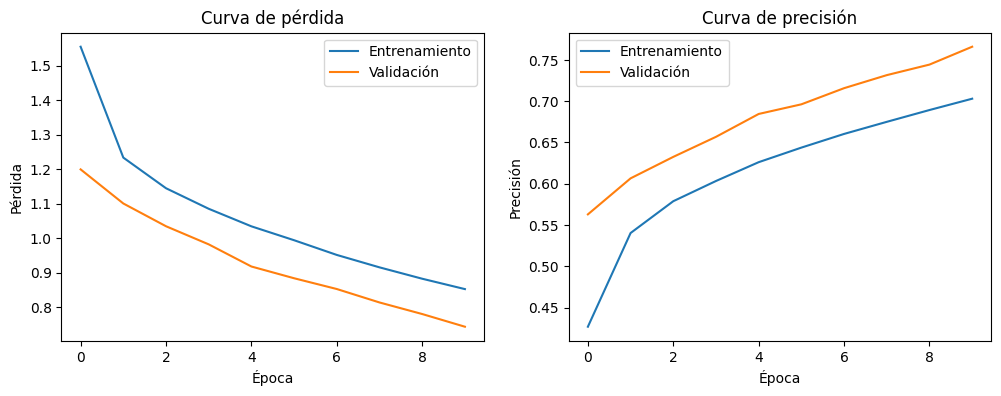

In [38]:
import matplotlib.pyplot as plt

train_loss = historyCNNBERTPAPER64.history['loss']
val_loss = historyCNNBERTPAPER64.history['val_loss']
train_accuracy = historyCNNBERTPAPER64.history['sparse_categorical_accuracy']
val_accuracy = historyCNNBERTPAPER64.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()